## **Preparation of data for plotting**

Here, we consider that all the networks of interest were already generated and saved. This way, we will augment the networks with extra information
and perform extra calculations to generate data ready for plotting.

Let us consider the two types of networks:<br>
1. **Cities flux networks**<br>
2. **Cities to Hospitals flux networks**<br>

## **-1. Lib**

In [3]:
# -- Bib
import os
import sys
sys.path.append("..")

from pathlib import Path
import networkx as nx
import geopandas as gpd
import pandas as pd
import glob
import locale
import pickle
from shapely.geometry import Point
import geopy
from geopy.distance import distance, geodesic
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import fluxsus.fluxnets.fnets_utils as futils
from tqdm import tqdm
import mapclassify

from fluxsus.preprocessing.processnet import NetProperties

PyTables is not installed. No support for HDF output.


In [4]:
idx = pd.IndexSlice

## **0. Load base data**

In [5]:
# -- base paths
basepath = Path.home().joinpath("Documents", "data")
#basepath = os.path.join(os.environ["HOMEPATH"], "Documents", "data")
#basepath = os.path.join(os.environ["HOME"], "Documents", "data")
cnespath = os.path.join(basepath, "opendatasus", "cnes")
geopath = os.path.join(basepath, "shapefilesceqgis")
gmlpath = os.path.join(basepath, "redes_aih")

In [6]:
# -- load geo
geodata_df = gpd.read_parquet(os.path.join(geopath, "ce_geodata.parquet"))
geodata_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   GEOCOD7            184 non-null    object  
 1   NM_MUNICIP         184 non-null    object  
 2   GEOCOD6            184 non-null    object  
 3   MACRO_ID           184 non-null    int64   
 4   CRES_ID            184 non-null    int64   
 5   geometry_municip   184 non-null    geometry
 6   MACRO_NOME         184 non-null    object  
 7   geometry_macro     184 non-null    geometry
 8   geometry_cres      184 non-null    geometry
 9   MACRO_ID_PROPOSAL  184 non-null    int64   
 10  centroid_municip   184 non-null    geometry
 11  municip_lon        184 non-null    float64 
 12  municip_lat        184 non-null    float64 
 13  2010               184 non-null    float64 
 14  2011               184 non-null    float64 
 15  2012               184 non-null    float64 
 16  

## **1. Maps of proposal**

**Current Macro**

In [20]:
# no preprocessing

**Proposal**

In [21]:
# no preprocessing

**Separate macros**

In [22]:
# no preprocessing

## **2. Population, Hospitals**

**2.1 City population 2010 and 2022**

In [23]:
# -- no processing

**2.2 Hospitals and hospital beds**

In [24]:
# -- no 

In [25]:
cnes_df = pd.read_parquet(os.path.join(cnespath, "cnes_st_0801_2312.parquet"))
cnes_df = cnes_df.merge(geodata_df[["GEOCOD6", "MACRO_ID", "MACRO_ID_PROPOSAL"]], left_on="CODUFMUN", right_on="GEOCOD6", how="left")

leitos_df = pd.read_parquet(os.path.join(cnespath, "cnes_leitos_timeserie_0801_2312.parquet"))
graph = nx.read_gml(os.path.join(gmlpath, "novo_completo", "citytohospitalnet_agg_1801_2306.gml"))

NameError: name 'lei' is not defined

In [ ]:
valid_cnes = []
for v in graph.nodes():
    if graph.nodes[v]['type']=='hospital' and graph.degree(v)>0:
        valid_cnes.append(graph.nodes[v]['code'])

valid_cnes_df = cnes_df[cnes_df["CNES"].isin(valid_cnes)]

**2.3 Geolocation of health units**

In [ ]:
# -- geolocation of hospitals
cols = ["CNES", "CODUFMUN", "MACRO_ID", "MACRO_ID_PROPOSAL", "latitude", "longitude", "COMPETEN_MAX", "COMPETEN_MIN"]
valid_cnes_df[cols].to_parquet(os.path.join(gmlpath, "dados_for_plot", "cnes_com_aih_1801_2306.parquet"))

In [ ]:
valid_cnes_df

,CNES,CODUFMUN,COD_CEP,CPF_CNPJ,PF_PJ,NIV_DEP,CNPJ_MAN,COD_IR,REGSAUDE,MICR_REG,...,AP05CV07,AP06CV07,AP07CV07,COMPETEN_MIN,COMPETEN_MAX,latitude,longitude,GEOCOD6,MACRO_ID,MACRO_ID_PROPOSAL
0,9999310,231130,63900085,00064176983353,1,1,00000000000000,None,None,None,...,0,0,0,201912,202312,-4.970753,-39.014854,231130,2,5
611,9675787,230440,60822131,32159518000169,3,1,00000000000000,None,None,None,...,0,0,0,201812,202312,-3.795548,-38.492201,230440,1,1
613,9672427,230760,62930000,00000000000000,3,3,07954571000104,None,010,None,...,0,0,0,201811,202312,-5.089599,-38.121126,230760,3,6
635,9658815,230440,60115081,31924394000106,3,1,00000000000000,None,None,None,...,0,0,0,201811,202312,-3.732426,-38.511244,230440,1,1
908,9526293,230440,60812030,00000000000000,3,3,04885197000144,None,0001,None,...,0,0,0,201806,202312,-3.771279,-38.474536,230440,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16457,0156647,230280,62700000,00000000000000,3,3,07963259000187,None,None,None,...,0,0,0,202005,202107,-4.361886,-39.313771,230280,2,5
16458,0153087,230640,62502612,00000000000000,3,3,07623077000167,None,0006,None,...,0,0,0,202005,202312,-3.496534,-39.597289,230640,1,2
16524,0104477,230440,60020061,00000000000000,3,3,04885197000144,None,0001,000001,...,0,0,0,202003,202012,-3.742621,-38.536761,230440,1,1
16525,0100358,231290,62011250,00000000000000,3,3,07598634000137,None,None,None,...,0,0,0,202003,202203,-3.685556,-40.345703,231290,4,8


In [ ]:
def get_leitos_municipio(municip_code, leitos_df, cnes_df, valid_cnes):
    cnes_of_municipio = cnes_df[(cnes_df["CODUFMUN"]==municip_code) & (cnes_df["CNES"].isin(valid_cnes))]["CNES"].tolist()
    if len(cnes_of_municipio)==0:
        return 0
    else:
        n_leitos_municipio = max(leitos_df.loc[:, idx[cnes_of_municipio, "NUMLEITOS_PRINC"]].sum(axis=1).tolist()[-5:])
        return n_leitos_municipio
    
def get_hospitais_municipio(municip_code, cnes_df, valid_cnes):
    cnes_of_municipio = cnes_df[(cnes_df["CODUFMUN"]==municip_code) & (cnes_df["CNES"].isin(valid_cnes))]["CNES"].tolist()
    return len(cnes_of_municipio)


muni_leitos, muni_hospitais = {}, {}
for muni in geodata_df["GEOCOD6"].tolist():
    n_leitos_municipio = get_leitos_municipio(muni, leitos_df, cnes_df, valid_cnes)
    n_hospitais_municipio = get_hospitais_municipio(muni, cnes_df, valid_cnes)
    muni_leitos[muni] = n_leitos_municipio
    muni_hospitais[muni] = n_hospitais_municipio

geodata_df["NUMLEITOS"] = geodata_df["GEOCOD6"].map(muni_leitos)
geodata_df["NUMHOSPITAIS"] = geodata_df["GEOCOD6"].map(muni_hospitais)
geodata_df[["GEOCOD6", "NUMLEITOS", "NUMHOSPITAIS"]].to_parquet(os.path.join(gmlpath, "dados_for_plot", "leitos_hospitais_por_municipio_1801_2306.parquet"))
geodata_df.head(3)

,GEOCOD7,NM_MUNICIP,GEOCOD6,MACRO_ID,CRES_ID,geometry_municip,MACRO_NOME,geometry_macro,geometry_cres,MACRO_ID_PROPOSAL,...,2016,2017,2018,2019,2020,2021,2022,MACRO_COLOR,NUMLEITOS,NUMHOSPITAIS
0,2300101,ABAIARA,230010,5,19,"POLYGON ((-39.08246 -7.29577, -39.08347 -7.292...",Superintendência Regional de Saúde Cariri,"POLYGON ((-38.67306 -6.70700, -38.67306 -6.707...","POLYGON ((-4354692.823 -865196.973, -4354812.2...",3,...,11380.0,11498.0,11619.0,11737.0,11853.0,11965.0,10038.0,#073b4c,0.0,0
1,2300150,ACARAPE,230015,1,3,"POLYGON ((-38.67268 -4.27393, -38.67268 -4.273...",Superintendência Regional de Saúde Fortaleza,"MULTIPOLYGON (((-39.69667 -2.99902, -39.69216 ...","POLYGON ((-4325426.833 -465433.632, -4325426.8...",1,...,14598.0,14707.0,14820.0,14929.0,15036.0,15140.0,14027.0,#ef476f,0.0,0
2,2300200,ACARAÚ,230020,4,12,"POLYGON ((-39.99113 -3.09797, -39.99117 -3.098...",Superintendência Regional de Saúde Norte,"MULTIPOLYGON (((-39.90892 -3.27414, -39.90892 ...","POLYGON ((-4503430.806 -312287.468, -4503430.7...",2,...,61208.0,61679.0,62165.0,62641.0,63104.0,63556.0,64806.0,#118ab2,38.0,1


**Stats per macro (Original)**

In [ ]:
# -- no processing

**Stats per macro (Proposta)**

In [ ]:
# -- no processing

## **3. Geodesic distance**

In [ ]:
# -- load geo
geodata_df = gpd.read_parquet(os.path.join(geopath, "ce_geodata.parquet"))

# -- create the two datasets
# -- one: geolocation of health units who genereated an AIH during 2018-2023 (this period can be flexible)
# -- two: geolocation of census units with the number of population contained in each unit
cnes_df = pd.read_parquet(os.path.join(cnespath, "cnes_st_0801_2312.parquet"))
cnes_df = cnes_df[["CNES", "CODUFMUN", "latitude", "longitude"]]
cnes_df = cnes_df.merge(geodata_df[["GEOCOD6", "MACRO_ID"]], left_on="CODUFMUN", right_on="GEOCOD6", how="left").drop("GEOCOD6", axis=1)

pop_census_df = gpd.read_parquet(os.path.join(geopath, "censo2010_pop_setores.parquet"))
pop_census_df1 = pop_census_df[["CD_GEOCODI", "CD_GEOCODM", "geometry", "Pop_setor_censo2010"]].copy()
pop_census_df1["GEOCOD6"] = pop_census_df1["CD_GEOCODM"].apply(lambda x: x[:6])
pop_census_df1 = pop_census_df1.merge(geodata_df[["GEOCOD6", "MACRO_ID"]], on="GEOCOD6", how="left")
pop_census_df1['centroid'] = pop_census_df1['geometry'].centroid
pop_census_df1 = pop_census_df1.drop('geometry', axis=1).rename({'centroid': 'geometry'}, axis=1).set_geometry('geometry')
pop_census_df1 = pop_census_df1.to_crs(epsg=29194).copy()

# -- the city-hospital bipartite network can provide which health units are actually relevant for analysis (generated at least one AIH during the period chosen)
graph = nx.read_gml(os.path.join(gmlpath, "novo_completo", "citytohospitalnet_agg_1801_2306.gml"))

# -- filter only the relevant health units
valid_cnes = [ graph.nodes[v]['code'] for v in graph.nodes() if graph.nodes[v]['type']=='hospital' and graph.degree(v)>0 ]
valid_cnes_df = cnes_df[cnes_df["CNES"].isin(valid_cnes)]

# -- define the geometry of the health units
valid_cnes_df["geometry"] = gpd.points_from_xy(valid_cnes_df.longitude, valid_cnes_df.latitude)
valid_cnes_df = gpd.GeoDataFrame(valid_cnes_df, geometry='geometry', crs="EPSG:4674")
# -- health units in projection for meters
valid_cnes_df1 = valid_cnes_df.to_crs(epsg=29194).copy()
#valid_cnes_df1 = valid_cnes_df.copy()

C:\Users\Higor Monteiro\AppData\Local\Temp\ipykernel_21676\1632097510.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  pop_census_df1['centroid'] = pop_census_df1['geometry'].centroid
C:\Users\Higor Monteiro\AppData\Local\Temp\ipykernel_21676\1632097510.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_cnes_df["geometry"] = gpd.points_from_xy(valid_cnes_df.longitude, valid_cnes_df.latitude)


In [ ]:
# -- distance from sectors to hospitals

macro_id = 2
subset_cnes = valid_cnes_df1[valid_cnes_df1["MACRO_ID"]==macro_id]
subset_pop_setor = pop_census_df1[pop_census_df1["MACRO_ID"]==macro_id]

for index in range(subset_cnes.shape[0]):
    current_point_cnes = subset_cnes.geometry.iloc[index]

macro_distances = subset_cnes.geometry.apply(lambda g: subset_pop_setor.distance(g)/1000).values.flatten() # km

In [ ]:
# -- distance from sectors to hospitals (weighted by population)

macro_id = 2
subset_cnes = valid_cnes_df1[valid_cnes_df1["MACRO_ID"]==macro_id]
subset_pop_setor = pop_census_df1[pop_census_df1["MACRO_ID"]==macro_id]

weighted_distances = []
for index in range(subset_cnes.shape[0]):
    current_point_cnes = subset_cnes.geometry.iloc[index]

    res = (subset_pop_setor.distance(current_point_cnes)/1000).apply(lambda x: [x] if pd.notna(x) else np.nan)*subset_pop_setor["Pop_setor_censo2010"].fillna(0).astype(int)
    weighted_distances.append(res)

weighted_distances = pd.concat(weighted_distances)

In [ ]:
base_dist = []
for lst in weighted_distances.values:
    base_dist += lst

In [ ]:
base_dist

[82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,
 82.27692298734185,


In [ ]:
bins = np.arange(0,305,10)
va1, _ = np.histogram(base_dist, bins)

**Macro distances (original)**

In [ ]:
# no processing

**Macro distances (proposta)**

In [ ]:
# no processing

## **4. CCA for hospitals**

**Plotting for CCA diagram**

In [ ]:
# -- no processing

In [ ]:
cnes_df

NameError: name 'cnes_df' is not defined

**Algorithm**

In [7]:
cnes_df = pd.read_parquet(os.path.join(cnespath, "cnes_st_0801_2312.parquet"))[["CNES", "latitude", "longitude"]]

# ---- geolocation of census tract units (brazil)
pop_census_df = gpd.read_parquet(os.path.join(geopath, "censo2010_pop_setores.parquet"))
pop_census_df1 = pop_census_df[["CD_GEOCODI", "Pop_setor_censo2010", "geometry"]].copy()
pop_census_df1['centroid'] = pop_census_df1['geometry'].centroid
pop_census_df1 = pop_census_df1.drop('geometry', axis=1).rename({'centroid': 'geometry'}, axis=1).set_geometry('geometry')

sihpath = os.path.join(basepath, "opendatasus", "sihsus", "PARQUET")
list_of_cnes = futils.list_of_cnes_with_aih(sihpath, "RDCE1801", "RDCE2306")
valid_cnes_df = cnes_df[cnes_df["CNES"].isin(list_of_cnes)]
valid_cnes_df["geometry"] = gpd.points_from_xy(valid_cnes_df.longitude, valid_cnes_df.latitude)
valid_cnes_df = gpd.GeoDataFrame(valid_cnes_df.drop(["latitude", "longitude"], axis=1), geometry='geometry', crs="EPSG:4674")

# -- standard identifier column
pop_census_df1 = pop_census_df1.rename({"CD_GEOCODI": "IDENT", "Pop_setor_censo2010": "Pop"}, axis=1)
valid_cnes_df = valid_cnes_df.rename({"CNES": "IDENT"}, axis=1)

C:\Users\Higor Monteiro\AppData\Local\Temp\ipykernel_27956\1709279215.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  pop_census_df1['centroid'] = pop_census_df1['geometry'].centroid
100%|██████████| 66/66 [00:07<00:00,  8.55it/s]
C:\Users\Higor Monteiro\AppData\Local\Temp\ipykernel_27956\1709279215.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_cnes_df["geometry"] = gpd.points_from_xy(valid_cnes_df.longitude, valid_cnes_df.latitude)


In [ ]:
for lhos in [4, 6, 8, 10, 12, 14, 16, 18, 20, 22]:
    print(lhos)
    sector_dfs = []
    for lsector in tqdm(np.arange(lhos, 38, 2)):
        sector_to_module, hospital_to_module = futils.cca_health(pop_census_df1, valid_cnes_df, lsector=lsector, lhos=lhos, ident_col="IDENT")
        curr_df = pd.DataFrame.from_dict(sector_to_module, orient='index').reset_index().rename({'index': "CD_GEOCODI", 0: f"module_lsec{lsector}_lhos{lhos}"}, axis=1).set_index("CD_GEOCODI").sort_index()
        sector_dfs.append(curr_df)
    sector_dfs = pd.concat(sector_dfs, axis=1)
    sector_dfs.to_parquet(os.path.join(gmlpath, "dados_for_plot", f"sector_modules_cca_lhosp{lhos}.parquet"))

4


100%|██████████| 17/17 [00:59<00:00,  3.51s/it]


6


100%|██████████| 16/16 [00:59<00:00,  3.70s/it]


8


100%|██████████| 15/15 [00:56<00:00,  3.77s/it]


10


100%|██████████| 14/14 [00:54<00:00,  3.89s/it]


12


100%|██████████| 13/13 [00:52<00:00,  4.02s/it]


14


100%|██████████| 12/12 [00:48<00:00,  4.05s/it]


16


100%|██████████| 11/11 [00:44<00:00,  4.07s/it]


18


100%|██████████| 10/10 [00:41<00:00,  4.17s/it]


20


100%|██████████| 9/9 [00:37<00:00,  4.13s/it]


22


100%|██████████| 8/8 [00:33<00:00,  4.24s/it]


In [8]:
pop_census_df2 = pop_census_df[["CD_GEOCODI", "Pop_setor_censo2010", "geometry"]].copy()

lsector_arr = np.arange(3, 11, 2)
for l in tqdm(lsector_arr):
    res0 = futils.cca(pop_census_df1, lsector=l, pop_threshold=0, ident_col="IDENT", pop_col="Pop")
    #res1 = futils.cca(pop_census_df1, lsector=l, pop_threshold=100, ident_col="IDENT", pop_col="Pop")
    #res2 = futils.cca(pop_census_df1, lsector=l, pop_threshold=200, ident_col="IDENT", pop_col="Pop")
    #res3 = futils.cca(pop_census_df1, lsector=l, pop_threshold=300, ident_col="IDENT", pop_col="Pop")
    #res4 = futils.cca(pop_census_df1, lsector=l, pop_threshold=400, ident_col="IDENT", pop_col="Pop")

    pop_census_df2[f"CCA_l{l}_D0"] = pop_census_df2["CD_GEOCODI"].map(res0)
    #pop_census_df2[f"CCA_l{l}_D100"] = pop_census_df2["CD_GEOCODI"].map(res1)
    #pop_census_df2[f"CCA_l{l}_D200"] = pop_census_df2["CD_GEOCODI"].map(res2)
    #pop_census_df2[f"CCA_l{l}_D300"] = pop_census_df2["CD_GEOCODI"].map(res3)
    #pop_census_df2[f"CCA_l{l}_D400"] = pop_census_df2["CD_GEOCODI"].map(res4)

pop_census_df2.to_parquet(os.path.join(gmlpath, "dados_for_plot", f"CCA_ceara1.parquet"))

100%|██████████| 4/4 [04:12<00:00, 63.20s/it]


In [9]:
#pop_census_df2 = gpd.read_parquet(os.path.join(gmlpath, "dados_for_plot", f"CCA_ceara1.parquet"))
#pop_census_df2

In [ ]:
pop_census_df2 = pop_census_df[["CD_GEOCODI", "Pop_setor_censo2010", "geometry"]].copy()
pop_census_df2["CCA_MODULE"] = pop_census_df2["CD_GEOCODI"].map(res)
pop_census_df2

,CD_GEOCODI,Pop_setor_censo2010,geometry,CCA_MODULE
0,230030925000003,377.0,"POLYGON ((-39.20836 -5.99972, -39.20669 -6.003...",220
1,230030925000004,199.0,"POLYGON ((-39.15934 -5.95675, -39.15934 -5.956...",223
2,230030925000005,636.0,"POLYGON ((-39.12753 -6.13781, -39.12883 -6.135...",224
3,230030925000006,437.0,"POLYGON ((-39.05327 -6.02270, -39.05228 -6.025...",225
4,230030925000007,409.0,"POLYGON ((-39.20957 -6.08720, -39.20973 -6.087...",220
...,...,...,...,...
13610,231410225000006,1207.0,"POLYGON ((-41.15081 -3.69669, -41.15011 -3.695...",13015
13611,231410225000007,622.0,"POLYGON ((-41.06812 -3.67289, -41.06719 -3.673...",13015
13612,231410225000008,474.0,"POLYGON ((-41.06597 -3.67783, -41.06623 -3.676...",13015
13613,231410225000009,283.0,"POLYGON ((-41.09994 -3.62549, -41.09974 -3.625...",13015


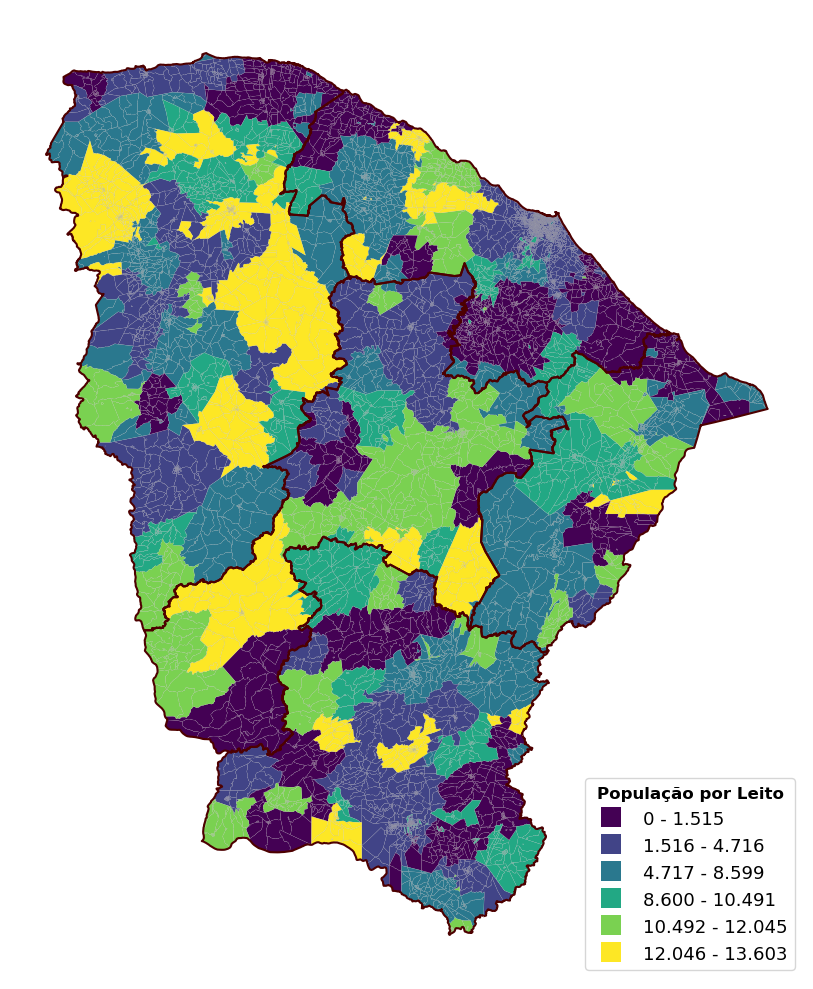

In [ ]:
def transf_label(index, label):
    label = label.replace("[", "").replace("]", "").replace("(", "")
    label = [ n.strip() for n in label.split(",") ]
    if len(label)==1:
        return label[0]
    if index==0:
        label[0] = int(label[0])
    else:
        label[0] = int(label[0])+1
    label[1] = int(label[1])
    return f'{label[0]:,} - {label[1]:,}'.replace(",",".")

# -- geometry ceará
fig_mapa, ax_mapa = plt.subplots(1,1, figsize=(15.5,10))

#cmap_range = colors = plt.cm.reds(np.linspace(0,1,18)) # -- colormap for the ranking

pop_census_df2.plot(ax=ax_mapa, column='CCA_MODULE', edgecolor="#b3b2b2", 
             legend=True,
             scheme="NaturalBreaks",
             k=6,
             cmap="viridis",
             linewidth=0.1,
             legend_kwds={
                 'loc': 4,
                 'prop': {'size':18},
                 'markerscale': 1.6,
                 "fmt": "{:.0f}",
                 "interval": True
             },
             missing_kwds={
                 "color": "#ffffff",
                 "edgecolor": "#404040",
                 "hatch": "xx",
                 "label": 'sem agregado',
                 'alpha': 0.4
             })

macro_df = geodata_df.drop_duplicates("MACRO_ID", keep='first')[["MACRO_ID", "MACRO_COLOR", "MACRO_NOME", "geometry_macro"]]
macro_df = macro_df.set_geometry("geometry_macro")
macro_df.plot(ax=ax_mapa, color="none", edgecolor="#4d0000", linewidth=1.5)

ax_mapa.axis('off')
ax_mapa.tick_params(which='both', length=0, labelsize=0)

for axis in [ax_mapa]:
    leg = axis.get_legend()
    lines = leg.get_lines()
    for line in lines:
        cur_color = line.get_markerfacecolor() 
        line.set_marker('s')
        line.set_markersize(15)
    current_labels = [t.get_text() for t in leg.get_texts()]
    new_labels =  [ transf_label(index, label) for index, label in enumerate(current_labels) ]
    axis.legend(lines, new_labels, prop={'size': 13}, loc=4, title='População por Leito', title_fontproperties={'weight': 'bold', 'size': 12})

fig_mapa.tight_layout()
#fig_mapa.suptitle(rf"$L = {l}$ km", fontsize=15)
#fig_mapa.savefig(os.path.join(figpath, f"pop_por_leitos_cca_cluster_l{l}km.png"), dpi=250, bbox_inches='tight')

## **5. Flux networks (city2city)**

**Infomap regarding to fluxes (normalized)**

In [25]:
trials = 20
suffix = 'agg_2001_2212'
fname = f'cityfluxnet_{suffix}.gml'
graph = nx.read_gml(os.path.join(gmlpath, 'novo_completo', fname))

# -- include 2022 population to nodes
pop_2022 = dict(zip(geodata_df['GEOCOD6'], geodata_df['2022']))

for v in graph.nodes():
    muncode = graph.nodes[v]['municipio_code']
    graph.nodes[v]['pop_2022'] = pop_2022[muncode]

# -- normalize flow based on the population
factor = 1000
for src, tgt in graph.edges():
    pop_src = graph.nodes[src]['pop_2022']
    outflow = graph.edges[src, tgt]['admission_count']
    outflow_cost = graph.edges[src, tgt]['total_cost']
    graph.edges[src, tgt]['admission_count_norm_pop'] = (outflow/pop_src)*factor
    graph.edges[src, tgt]['total_cost_norm_pop'] = (outflow_cost/pop_src)

# -- calculate in and out flow for each node
graph_prop = NetProperties(graph)
graph_prop.calculate_in_flow(weight_people_col='admission_count', weight_cost_col='total_cost').calculate_out_flow(weight_people_col='admission_count', weight_cost_col='total_cost')
graph_prop.process_infomap_graph(trials=trials, weight_people_col='admission_count_norm_pop', weight_cost_col='total_cost_norm_pop', people_property_name='infomap_count_norm_pop_mod_id', cost_property_name='infomap_cost_norm_pop_mod_id')

# -- create dict for infomap modules
infomap_code_to_mod_count = dict()
infomap_code_to_mod_cost = dict()
for v in graph.nodes():
    muncode = graph.nodes[v]['municipio_code']
    module_id1 = graph.nodes[v]['infomap_count_norm_pop_mod_id']
    module_id2 = graph.nodes[v]['infomap_cost_norm_pop_mod_id']
    infomap_code_to_mod_count.update({muncode:module_id1})
    infomap_code_to_mod_cost.update({muncode:module_id2})

geodata_df_mod = geodata_df.copy()
geodata_df_mod["infomap_modules_count_norm_pop"] = geodata_df_mod["GEOCOD6"].map(infomap_code_to_mod_count)
geodata_df_mod["infomap_modules_cost_norm_pop"] = geodata_df_mod["GEOCOD6"].map(infomap_code_to_mod_cost)

# -- uncomment only when there discontiguous cluister because of zero flow -> it sets manually the cluster id
#fortaleza_module = geodata_df_mod[geodata_df_mod["NM_MUNICIP"]=="FORTALEZA"]["infomap_modules_count_norm_pop"].iat[0]
#crato_module = geodata_df_mod[geodata_df_mod["NM_MUNICIP"]=="CRATO"]["infomap_modules_count_norm_pop"].iat[0]
#geodata_df_mod['infomap_modules_count_norm_pop'] = geodata_df_mod[['NM_MUNICIP', "infomap_modules_count_norm_pop"]].apply(lambda x: x['infomap_modules_count_norm_pop'] if x["NM_MUNICIP"]!='IBICUITINGA' else fortaleza_module, axis=1)
#geodata_df_mod['infomap_modules_count_norm_pop'] = geodata_df_mod[['NM_MUNICIP', "infomap_modules_count_norm_pop"]].apply(lambda x: x['infomap_modules_count_norm_pop'] if x["NM_MUNICIP"]!='ABAIARA' else crato_module, axis=1)

cols = ["GEOCOD6", "infomap_modules_count_norm_pop", "infomap_modules_cost_norm_pop"]
geodata_df_mod[cols].to_parquet(os.path.join(gmlpath, "dados_for_plot", f"geocod_to_infomap_modules_{suffix}_trials_{trials}.parquet"))

found 11 modules with codelength: 2.493866736423275
found 5 modules with codelength: 2.541985808993333


In [24]:
fortaleza_module = geodata_df_mod[geodata_df_mod["NM_MUNICIP"]=="FORTALEZA"]["infomap_modules_count_norm_pop"].iat[0]
crato_module = geodata_df_mod[geodata_df_mod["NM_MUNICIP"]=="CRATO"]["infomap_modules_count_norm_pop"].iat[0]

geodata_df_mod['infomap_modules_count_norm_pop'] = geodata_df_mod[['NM_MUNICIP', "infomap_modules_count_norm_pop"]].apply(lambda x: x['infomap_modules_count_norm_pop'] if x["NM_MUNICIP"]!='IBICUITINGA' else fortaleza_module, axis=1)
geodata_df_mod['infomap_modules_count_norm_pop'] = geodata_df_mod[['NM_MUNICIP', "infomap_modules_count_norm_pop"]].apply(lambda x: x['infomap_modules_count_norm_pop'] if x["NM_MUNICIP"]!='ABAIARA' else crato_module, axis=1)

In [15]:
for v in graph.nodes():
    print(graph.nodes[v])
    break

{'municipio_code': '230010', 'municipio_name': 'ABAIARA', 'macro_id': 5, 'macro_new_id': 3, 'macro_name': 'Superintendência Regional de Saúde Cariri', 'cres_id': 19, 'lat': -7.35990681440754, 'lon': -39.03753839591732}


**Infomap to the Infomap Fortaleza Cluster**

In [19]:
infomap_mod = fortaleza_module

suffix = 'agg_1801_2212'
fname = f'cityfluxnet_{suffix}.gml'
graph = nx.read_gml(os.path.join(gmlpath, 'novo_completo', fname))

municip_to_consider = geodata_df_mod[geodata_df_mod['infomap_modules_count_norm_pop']==fortaleza_module]["GEOCOD6"].tolist()
print(municip_to_consider)

# -- filter graph
nodes_to_remove = []
for v in graph.nodes():
    cur_municip = graph.nodes[v]['municipio_code']
    if cur_municip not in municip_to_consider:
        nodes_to_remove.append(v)
graph.remove_nodes_from(nodes_to_remove)

# -- include 2022 population to nodes
pop_2022 = dict(zip(geodata_df['GEOCOD6'], geodata_df['2022']))

for v in graph.nodes():
    muncode = graph.nodes[v]['municipio_code']
    graph.nodes[v]['pop_2022'] = pop_2022[muncode]

# -- normalize flow based on the population
factor = 1000
for src, tgt in graph.edges():
    pop_src = graph.nodes[src]['pop_2022']
    outflow = graph.edges[src, tgt]['admission_count']
    outflow_cost = graph.edges[src, tgt]['total_cost']
    graph.edges[src, tgt]['admission_count_norm_pop'] = (outflow/pop_src)*factor
    graph.edges[src, tgt]['total_cost_norm_pop'] = (outflow_cost/pop_src)

# -- calculate in and out flow for each node
graph_prop = NetProperties(graph)
graph_prop.calculate_in_flow(weight_people_col='admission_count', weight_cost_col='total_cost').calculate_out_flow(weight_people_col='admission_count', weight_cost_col='total_cost')
graph_prop.process_infomap_graph(trials=50, weight_people_col='admission_count_norm_pop', weight_cost_col='total_cost_norm_pop', people_property_name='infomap_count_norm_pop_mod_id', cost_property_name='infomap_cost_norm_pop_mod_id')

# -- create dict for infomap modules
infomap_code_to_mod_count = dict()
infomap_code_to_mod_cost = dict()
for v in graph.nodes():
    muncode = graph.nodes[v]['municipio_code']
    module_id1 = graph.nodes[v]['infomap_count_norm_pop_mod_id']
    module_id2 = graph.nodes[v]['infomap_cost_norm_pop_mod_id']
    infomap_code_to_mod_count.update({muncode:module_id1})
    infomap_code_to_mod_cost.update({muncode:module_id2})

geodata_df_mod = geodata_df.copy()
geodata_df_mod["infomap_modules_count_norm_pop"] = geodata_df_mod["GEOCOD6"].map(infomap_code_to_mod_count)
geodata_df_mod["infomap_modules_cost_norm_pop"] = geodata_df_mod["GEOCOD6"].map(infomap_code_to_mod_count)

cols = ["GEOCOD6", "infomap_modules_count_norm_pop", "infomap_modules_cost_norm_pop"]
geodata_df_mod[cols].to_parquet(os.path.join(gmlpath, "dados_for_plot", f"geocod_to_infomap_modules_{suffix}_trials_{trials}_infomap_of_fortaleza.parquet"))

['230015', '230090', '230100', '230110', '230185', '230195', '230220', '230350', '230370', '230393', '230395', '230428', '230440', '230445', '230460', '230495', '230523', '230526', '230533', '230535', '230620', '230625', '230630', '230765', '230770', '230835', '230945', '230960', '230970', '231010', '231020', '231025', '231050', '231070', '231085', '231130', '231140', '231160', '231240', '231260', '231270', '231300', '231335']
found 39 modules with codelength: 2.1079098094730297
found 37 modules with codelength: 2.0250889188035637


In [8]:
for u, v in graph.edges():
    print(graph.edges[u,v])
    break

{'admission_count': 27, 'total_cost': 16354.65, 'source_macro': 5.0, 'target_macro': 5, 'source_micro': 19.0, 'target_micro': 19, 'same_macro': 5.0, 'same_micro': 19.0, 'admission_count_ch1': 0.0, 'total_cost_ch1': 0.0, 'admission_count_ch2': 0.0, 'total_cost_ch2': 0.0, 'admission_count_ch3': 0.0, 'total_cost_ch3': 0.0, 'admission_count_ch4': 0.0, 'total_cost_ch4': 0.0, 'admission_count_ch5': 0.0, 'total_cost_ch5': 0.0, 'admission_count_ch6': 0.0, 'total_cost_ch6': 0.0, 'admission_count_ch7': 0.0, 'total_cost_ch7': 0.0, 'admission_count_ch8': 0.0, 'total_cost_ch8': 0.0, 'admission_count_ch9': 0.0, 'total_cost_ch9': 0.0, 'admission_count_ch10': 0.0, 'total_cost_ch10': 0.0, 'admission_count_ch11': 6.0, 'total_cost_ch11': 3420.04, 'admission_count_ch12': 0.0, 'total_cost_ch12': 0.0, 'admission_count_ch13': 1.0, 'total_cost_ch13': 948.13, 'admission_count_ch14': 6.0, 'total_cost_ch14': 2934.94, 'admission_count_ch15': 14.0, 'total_cost_ch15': 9051.54, 'admission_count_ch16': 0.0, 'total_co

**Infomap to isolated macros (original)**

In [ ]:
macro_id = 5

suffix = 'agg_1801_2212'
fname = f'cityfluxnet_{suffix}.gml'
graph = nx.read_gml(os.path.join(gmlpath, 'novo_completo', fname))

# -- filter graph
nodes_to_remove = []
for v in graph.nodes():
    cur_macro = graph.nodes[v]['macro_id']
    if cur_macro!=macro_id:
        nodes_to_remove.append(v)
graph.remove_nodes_from(nodes_to_remove)

# -- include 2022 population to nodes
pop_2022 = dict(zip(geodata_df['GEOCOD6'], geodata_df['2022']))

for v in graph.nodes():
    muncode = graph.nodes[v]['municipio_code']
    graph.nodes[v]['pop_2022'] = pop_2022[muncode]

# -- normalize flow based on the population
factor = 1000
for src, tgt in graph.edges():
    pop_src = graph.nodes[src]['pop_2022']
    outflow = graph.edges[src, tgt]['admission_count']
    outflow_cost = graph.edges[src, tgt]['total_cost']
    graph.edges[src, tgt]['admission_count_norm_pop'] = (outflow/pop_src)*factor
    graph.edges[src, tgt]['total_cost_norm_pop'] = (outflow_cost/pop_src)

# -- calculate in and out flow for each node
graph_prop = NetProperties(graph)
graph_prop.calculate_in_flow(weight_people_col='admission_count', weight_cost_col='total_cost').calculate_out_flow(weight_people_col='admission_count', weight_cost_col='total_cost')
graph_prop.process_infomap_graph(weight_people_col='admission_count_norm_pop', weight_cost_col='total_cost_norm_pop', people_property_name='infomap_count_norm_pop_mod_id', cost_property_name='infomap_cost_norm_pop_mod_id')

# -- create dict for infomap modules
infomap_code_to_mod_count = dict()
infomap_code_to_mod_cost = dict()
for v in graph.nodes():
    muncode = graph.nodes[v]['municipio_code']
    module_id1 = graph.nodes[v]['infomap_count_norm_pop_mod_id']
    module_id2 = graph.nodes[v]['infomap_cost_norm_pop_mod_id']
    infomap_code_to_mod_count.update({muncode:module_id1})
    infomap_code_to_mod_cost.update({muncode:module_id2})

geodata_df_mod = geodata_df.copy()
geodata_df_mod["infomap_modules_count_norm_pop"] = geodata_df_mod["GEOCOD6"].map(infomap_code_to_mod_count)
geodata_df_mod["infomap_modules_cost_norm_pop"] = geodata_df_mod["GEOCOD6"].map(infomap_code_to_mod_count)

cols = ["GEOCOD6", "infomap_modules_count_norm_pop", "infomap_modules_cost_norm_pop"]
geodata_df_mod[cols].to_parquet(os.path.join(gmlpath, "dados_for_plot", f"geocod_to_infomap_modules_{suffix}_macro{macro_id}.parquet"))

found 33 modules with codelength: 2.026331136465984
found 35 modules with codelength: 1.6318107450203745


**Infomap to isolated macros (proposal)**

In [ ]:
macro_id = 1

suffix = 'agg_1801_2306'
fname = f'cityfluxnet_{suffix}.gml'
graph = nx.read_gml(os.path.join(gmlpath, 'novo_completo', fname))

# -- filter graph
nodes_to_remove = []
for v in graph.nodes():
    cur_macro = graph.nodes[v]['macro_new_id']
    if cur_macro!=macro_id:
        nodes_to_remove.append(v)
graph.remove_nodes_from(nodes_to_remove)

# -- include 2022 population to nodes
pop_2022 = dict(zip(geodata_df['GEOCOD6'], geodata_df['2022']))

for v in graph.nodes():
    muncode = graph.nodes[v]['municipio_code']
    graph.nodes[v]['pop_2022'] = pop_2022[muncode]

# -- normalize flow based on the population
factor = 1000
for src, tgt in graph.edges():
    pop_src = graph.nodes[src]['pop_2022']
    outflow = graph.edges[src, tgt]['admission_count']
    outflow_cost = graph.edges[src, tgt]['total_cost']
    graph.edges[src, tgt]['admission_count_norm_pop'] = (outflow/pop_src)*factor
    graph.edges[src, tgt]['total_cost_norm_pop'] = (outflow_cost/pop_src)

# -- calculate in and out flow for each node
graph_prop = NetProperties(graph)
graph_prop.calculate_in_flow(weight_people_col='admission_count', weight_cost_col='total_cost').calculate_out_flow(weight_people_col='admission_count', weight_cost_col='total_cost')
graph_prop.process_infomap_graph(weight_people_col='admission_count_norm_pop', weight_cost_col='total_cost_norm_pop', people_property_name='infomap_count_norm_pop_mod_id', cost_property_name='infomap_cost_norm_pop_mod_id')

# -- create dict for infomap modules
infomap_code_to_mod_count = dict()
infomap_code_to_mod_cost = dict()
for v in graph.nodes():
    muncode = graph.nodes[v]['municipio_code']
    module_id1 = graph.nodes[v]['infomap_count_norm_pop_mod_id']
    module_id2 = graph.nodes[v]['infomap_cost_norm_pop_mod_id']
    infomap_code_to_mod_count.update({muncode:module_id1})
    infomap_code_to_mod_cost.update({muncode:module_id2})

geodata_df_mod = geodata_df.copy()
geodata_df_mod["infomap_modules_count_norm_pop"] = geodata_df_mod["GEOCOD6"].map(infomap_code_to_mod_count)
geodata_df_mod["infomap_modules_cost_norm_pop"] = geodata_df_mod["GEOCOD6"].map(infomap_code_to_mod_count)

cols = ["GEOCOD6", "infomap_modules_count_norm_pop", "infomap_modules_cost_norm_pop"]
geodata_df_mod[cols].to_parquet(os.path.join(gmlpath, "dados_for_plot", f"geocod_to_infomap_modules_{suffix}_macronew{macro_id}.parquet"))

found 24 modules with codelength: 1.8560111748816774
found 23 modules with codelength: 1.7807361666002661


### **Table with fluxes**

In [101]:
suffix = 'agg_2201_2212'
fname = f'cityfluxnet_{suffix}.gml'
graph = nx.read_gml(os.path.join(gmlpath, 'novo_completo', fname))

# -- include 2022 population to nodes
pop_2022 = dict(zip(geodata_df['GEOCOD6'], geodata_df['2022']))

for v in graph.nodes():
    muncode = graph.nodes[v]['municipio_code']
    graph.nodes[v]['pop_2022'] = pop_2022[muncode]

# -- calculate in and out flow for each node
graph_prop = NetProperties(graph)
graph_prop.calculate_in_flow(weight_people_col='admission_count', weight_cost_col='total_cost').calculate_out_flow(weight_people_col='admission_count', weight_cost_col='total_cost')

factor = 100000
table = {
    "GEOCOD6": [], "População 2022": [], "Entrada\nde\nPacientes": [], "Saída\nde\nPacientes": [],
    "Entrada de Pacientes\n(Por 100.000 hab)": [], "Saída de Pacientes\n(Por 100.000 hab)": [],
    "Entrada\nde\nCustos": [], "Saída\nde\nCustos": [],
    "Entrada de Custos\n(Por 100.000 hab)": [], "Saída de Custos\n(Por 100.000 hab)": [],
}
for v in graph.nodes():
    muncode = graph.nodes[v]['municipio_code']
    pop_src = graph.nodes[v]['pop_2022']
    in_people, out_people = graph.nodes[v]['incoming_people'], graph.nodes[v]['out_people']
    in_cost, out_cost = graph.nodes[v]['incoming_cost'], graph.nodes[v]['out_cost']
    in_people_norm, out_people_norm = (in_people/pop_src)*factor, (out_people/pop_src)*factor
    in_cost_norm, out_cost_norm = (in_cost/pop_src)*factor, (out_cost/pop_src)*factor

    table["GEOCOD6"].append(muncode)
    table["População 2022"].append(pop_src)
    table["Entrada\nde\nPacientes"].append(in_people)
    table["Saída\nde\nPacientes"].append(out_people)
    table["Entrada de Pacientes\n(Por 100.000 hab)"].append(in_people_norm)
    table["Saída de Pacientes\n(Por 100.000 hab)"].append(out_people_norm)
    table["Entrada\nde\nCustos"].append(in_cost)
    table["Saída\nde\nCustos"].append(out_cost)
    table["Entrada de Custos\n(Por 100.000 hab)"].append(in_cost_norm)
    table["Saída de Custos\n(Por 100.000 hab)"].append(out_cost_norm)


table = pd.DataFrame.from_dict(table)
table = table.merge(geodata_df[["GEOCOD6", "NM_MUNICIP"]], how="left")
table

,GEOCOD6,População 2022,Entrada\nde\nPacientes,Saída\nde\nPacientes,Entrada de Pacientes\n(Por 100.000 hab),Saída de Pacientes\n(Por 100.000 hab),Entrada\nde\nCustos,Saída\nde\nCustos,Entrada de Custos\n(Por 100.000 hab),Saída de Custos\n(Por 100.000 hab),NM_MUNICIP
0,230010,10038.0,0,496,0.000000,4941.223351,0.00,708544.04,0.000000e+00,7.058618e+06,ABAIARA
1,230015,14027.0,0,685,0.000000,4883.439082,0.00,914979.31,0.000000e+00,6.522986e+06,ACARAPE
2,230020,64806.0,1905,1238,2939.542635,1910.316946,850294.97,2828648.26,1.312062e+06,4.364794e+06,ACARAÚ
3,230030,44962.0,162,781,360.304257,1737.022374,95439.82,2126561.33,2.122677e+05,4.729686e+06,ACOPIARA
4,230040,14076.0,4,604,28.417164,4290.991759,1114.26,673458.06,7.916027e+03,4.784442e+06,AIUABA
...,...,...,...,...,...,...,...,...,...,...,...
179,231380,20189.0,0,1106,0.000000,5478.230720,0.00,1601957.38,0.000000e+00,7.934803e+06,URUBURETAMA
180,231390,13746.0,3,528,21.824531,3841.117416,404.15,835925.30,2.940128e+03,6.081226e+06,URUOCA
181,231395,18105.0,1,761,5.523336,4203.258768,300.62,1452252.36,1.660425e+03,8.021278e+06,VARJOTA
182,231400,38984.0,818,797,2098.296737,2044.428483,387537.77,2519958.27,9.940944e+05,6.464083e+06,VÁRZEA ALEGRE


**Internal**

In [97]:
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')
cols = ["NM_MUNICIP", "População 2022", "Entrada\nde\nPacientes", "Entrada de Pacientes\n(Por 100.000 hab)", "Entrada\nde\nCustos", "Entrada de Custos\n(Por 100.000 hab)"]
table1 = table[cols].rename({"NM_MUNICIP": "Município"}, axis=1)
table1 = table1.sort_values(by="Entrada de Custos\n(Por 100.000 hab)", ascending=False)
table1["População 2022"] = table1["População 2022"].apply(lambda x: locale.format('%d', x, grouping = True))
table1["Entrada\nde\nPacientes"] = table1["Entrada\nde\nPacientes"].apply(lambda x: locale.format('%d', x, grouping = True))
table1["Entrada de Pacientes\n(Por 100.000 hab)"] = table1["Entrada de Pacientes\n(Por 100.000 hab)"].apply(lambda x: locale.format('%.1f', x, grouping = True))
table1["Entrada\nde\nCustos"] = table1["Entrada\nde\nCustos"].apply(lambda x: locale.currency(x, grouping=True, symbol=True))
table1["Entrada de Custos\n(Por 100.000 hab)"] = table1["Entrada de Custos\n(Por 100.000 hab)"].apply(lambda x: locale.currency(x, grouping=True, symbol=True))
#table1 = table1.sort_values(by="Entrada de Pacientes\n(Por 100.000 hab)", ascending=False)
table1[:10]

C:\Users\Higor Monteiro\AppData\Local\Temp\ipykernel_2492\1060813987.py:5: DeprecationWarning: This method will be removed in a future version of Python. Use 'locale.format_string()' instead.
  table1["População 2022"] = table1["População 2022"].apply(lambda x: locale.format('%d', x, grouping = True))
C:\Users\Higor Monteiro\AppData\Local\Temp\ipykernel_2492\1060813987.py:6: DeprecationWarning: This method will be removed in a future version of Python. Use 'locale.format_string()' instead.
  table1["Entrada\nde\nPacientes"] = table1["Entrada\nde\nPacientes"].apply(lambda x: locale.format('%d', x, grouping = True))
C:\Users\Higor Monteiro\AppData\Local\Temp\ipykernel_2492\1060813987.py:7: DeprecationWarning: This method will be removed in a future version of Python. Use 'locale.format_string()' instead.
  table1["Entrada de Pacientes\n(Por 100.000 hab)"] = table1["Entrada de Pacientes\n(Por 100.000 hab)"].apply(lambda x: locale.format('%.1f', x, grouping = True))


,Município,População 2022,Entrada\nde\nPacientes,Entrada de Pacientes\n(Por 100.000 hab),Entrada\nde\nCustos,Entrada de Custos\n(Por 100.000 hab)
22,BARBALHA,75.033,9.391,"12.515,8","R$ 31.318.322,79","R$ 41.739.398,38"
166,SOBRAL,203.023,22.985,"11.321,4","R$ 50.287.819,66","R$ 24.769.518,56"
150,QUIXERAMOBIM,82.122,6.147,"7.485,2","R$ 10.513.397,80","R$ 12.802.169,70"
30,BREJO SANTO,51.090,4.076,"7.978,1","R$ 5.011.886,47","R$ 9.809.916,75"
101,LIMOEIRO DO NORTE,59.560,3.754,"6.302,9","R$ 4.795.734,11","R$ 8.051.937,73"
58,FORTALEZA,2.428.678,79.681,"3.280,8","R$ 176.926.372,21","R$ 7.284.883,88"
50,CRATO,131.050,5.165,"3.941,2","R$ 7.056.967,39","R$ 5.384.942,69"
87,ITAPIPOCA,131.123,4.966,"3.787,3","R$ 6.509.209,91","R$ 4.964.201,48"
171,TAUÁ,61.223,2.341,"3.823,7","R$ 2.827.734,74","R$ 4.618.745,80"
98,JUAZEIRO DO NORTE,286.120,5.822,"2.034,8","R$ 12.148.854,13","R$ 4.246.069,53"


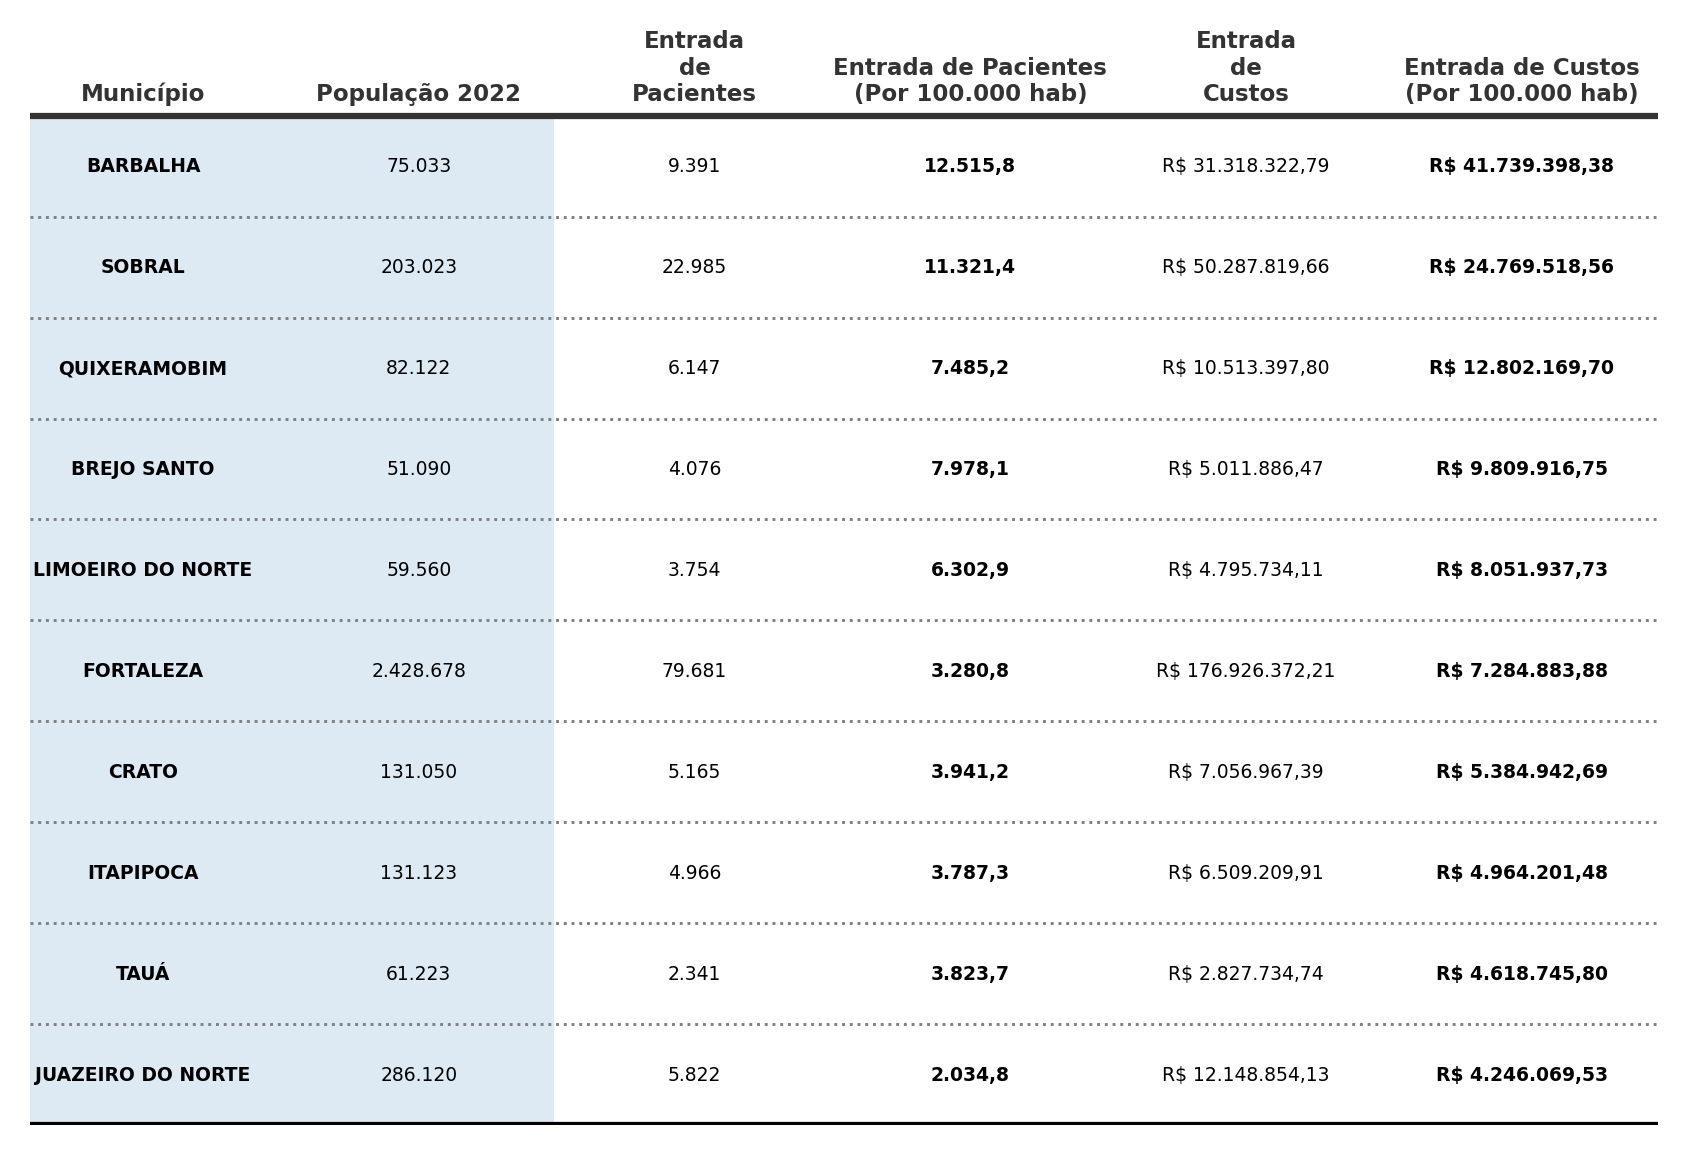

In [122]:
table_print = table1[:10][::-1].copy()

fig, ax = plt.subplots(1, figsize=(7,4.5), dpi=300)

ncols = len(table_print.columns)
nrows = table_print.shape[0]

ax.set_xlim(-1., ncols + 11)
ax.set_ylim(0, nrows+0.3)

positions = np.linspace(0.25, 15.5, ncols)
#positions = [0.25, 2., 3.3, 4.6, 5.9, ]
columns = list(table_print.columns)

# Add table's main text
for i in range(nrows):
    for j, column in enumerate(columns):
        if j == 0:
            ha = 'center'
        else:
            ha = 'center'
        v = table_print[column].iat[i]
        cus_weight = 'normal'
        if column in ["Município", "Entrada de Pacientes\n(Por 100.000 hab)", "Entrada de Custos\n(Por 100.000 hab)"]:
             fontsize = 5.5
             cus_weight = 'bold'
             if column=="Município":
                fontsize = 4.5
        
        ax.annotate(
            xy=(positions[j], i + .5),
            text=v,
            ha=ha,
            va='center',
            fontsize=4.5,
            weight=cus_weight
        )

# Add column names
column_names = cols
for index, c in enumerate(columns):
        if index == 0:
            ha = 'center'
        else:
            ha = 'center'
        name = columns[index]
        fontsize = 5.5
        va = 'bottom'
        ax.annotate(
            xy=(positions[index], nrows+0.1),
            text=columns[index],
            color="#333333",
            ha=ha,
            va=va,
            weight='bold',
            fontsize=fontsize,
        )

ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw=1.5, color='#333333', marker='', zorder=4)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)
for x in range(1, nrows):
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw=.7, color='gray', ls=':', zorder=3 , marker='')

ax.fill_between(
    x=[-1,4.8],
    y1=nrows,
    y2=0,
    color='tab:blue',
    alpha=0.15,
    ec='None'
)

ax.set_axis_off()
fig.savefig(basepath.joinpath("redes_aih", "doc_final", f"entrada_fluxo_municipios_top10_2022.png"), dpi=250, bbox_inches='tight')

c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


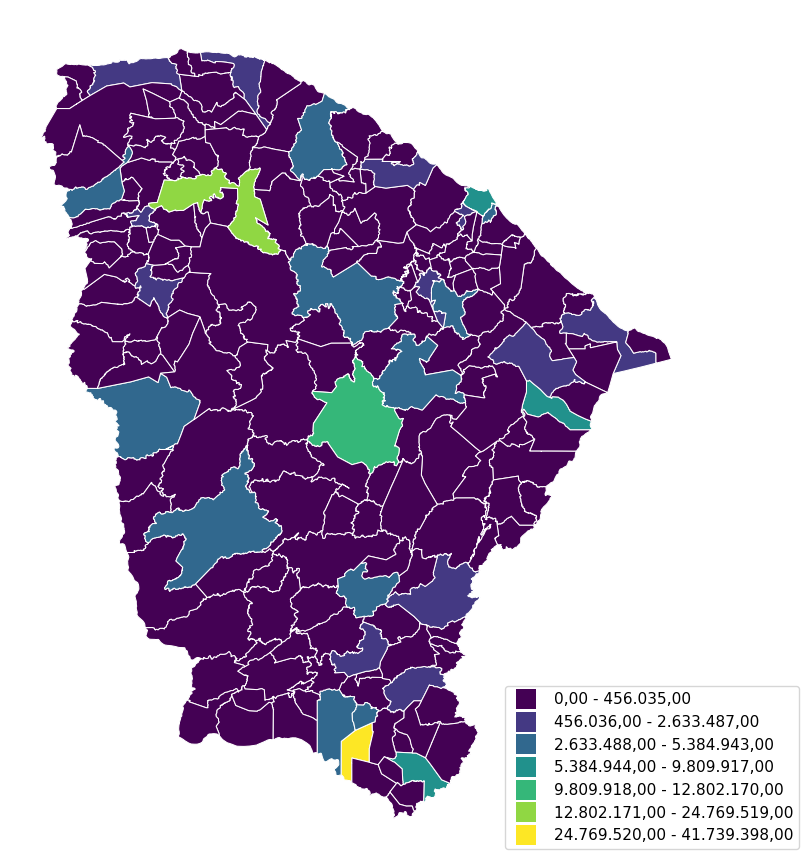

In [145]:
def transf_label(index, label, counts=None):
    label = label.replace("[", "").replace("]", "").replace("(", "")
    label = [ n.strip() for n in label.split(",") ]
    if len(label)==1:
        return label[0]
    if index==0:
        label[0] = int(label[0])
    else:
        label[0] = int(label[0])+1
    label[1] = int(label[1])
    if counts is None:
        return f'{locale.currency(label[0], grouping=True, symbol=False)} - {locale.currency(label[1], grouping=True, symbol=False)}'
    else:
        return f'{locale.currency(label[0], grouping=True, symbol=False)} - {locale.currency(label[1], grouping=True, symbol=True)} ({counts[index]})'

fig, ax = plt.subplots(1, figsize=(12,11))

geodata_df_temp1 = geodata_df.merge(table[["GEOCOD6", "Entrada de Custos\n(Por 100.000 hab)"]], how="left")
map_counts = mapclassify.NaturalBreaks(geodata_df_temp1["Entrada de Custos\n(Por 100.000 hab)"], k=8).counts
geodata_df_temp1.plot(ax=ax, zorder=3, column="Entrada de Custos\n(Por 100.000 hab)", edgecolor="#ffffff", 
             legend=True,
             scheme="NaturalBreaks",
             k=7,
             cmap="viridis",
             linewidth=0.75,
             legend_kwds={
                 'loc': 4,
                 'prop': {'size':18},
                 'markerscale': 1.6,
                 "fmt": "{:.0f}",
                 "interval": True
             },
             missing_kwds={
                 "color": "#ffffff",
                 "edgecolor": "#404040",
                 "hatch": "///",
                 "label": '',
                 'alpha': 0.45
             })
ax.axis('off')

for index, axis in enumerate([ax]):
    leg = axis.get_legend()
    lines = leg.get_lines()
    for line in lines:
        cur_color = line.get_markerfacecolor() 
        line.set_marker('s')
        line.set_markersize(15)
    current_labels = [t.get_text() for t in leg.get_texts()]
    new_labels =  [ transf_label(index, label) for index, label in enumerate(current_labels) ]
    axis.legend(lines, new_labels, prop={'size': 11}, bbox_to_anchor=(1.15, 0.0), loc=4, title='',  title_fontproperties={'weight': 'bold', 'size': 12})
#ce_df.plot(ax=AX1, color='none', edgecolor="#333333", linewidth=2)
#macro_df.plot(ax=AX1, color="none", zorder=3, edgecolor="#1a1a1a", linewidth=2.0)
fig.savefig(basepath.joinpath("redes_aih", "doc_final", f"entrada_fluxo_municipios_top10_2022_mapa.png"), dpi=250, bbox_inches='tight')

**External**

In [102]:
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')
cols = ["NM_MUNICIP", "População 2022", "Saída\nde\nPacientes", "Saída de Pacientes\n(Por 100.000 hab)", "Saída\nde\nCustos", "Saída de Custos\n(Por 100.000 hab)"]
table2 = table[cols].rename({"NM_MUNICIP": "Município"}, axis=1)
table2 = table2.sort_values(by="Saída de Custos\n(Por 100.000 hab)", ascending=False)
table2["População 2022"] = table2["População 2022"].apply(lambda x: locale.format('%d', x, grouping = True))
table2["Saída\nde\nPacientes"] = table2["Saída\nde\nPacientes"].apply(lambda x: locale.format('%d', x, grouping = True))
table2["Saída de Pacientes\n(Por 100.000 hab)"] = table2["Saída de Pacientes\n(Por 100.000 hab)"].apply(lambda x: locale.format('%.1f', x, grouping = True))
table2["Saída\nde\nCustos"] = table2["Saída\nde\nCustos"].apply(lambda x: locale.currency(x, grouping=True, symbol=True))
table2["Saída de Custos\n(Por 100.000 hab)"] = table2["Saída de Custos\n(Por 100.000 hab)"].apply(lambda x: locale.currency(x, grouping=True, symbol=True))
#table2 = table2.sort_values(by="Entrada de Pacientes\n(Por 100.000 hab)", ascending=False)
table2[:10]

C:\Users\Higor Monteiro\AppData\Local\Temp\ipykernel_2492\1584579216.py:5: DeprecationWarning: This method will be removed in a future version of Python. Use 'locale.format_string()' instead.
  table2["População 2022"] = table2["População 2022"].apply(lambda x: locale.format('%d', x, grouping = True))
C:\Users\Higor Monteiro\AppData\Local\Temp\ipykernel_2492\1584579216.py:6: DeprecationWarning: This method will be removed in a future version of Python. Use 'locale.format_string()' instead.
  table2["Saída\nde\nPacientes"] = table2["Saída\nde\nPacientes"].apply(lambda x: locale.format('%d', x, grouping = True))
C:\Users\Higor Monteiro\AppData\Local\Temp\ipykernel_2492\1584579216.py:7: DeprecationWarning: This method will be removed in a future version of Python. Use 'locale.format_string()' instead.
  table2["Saída de Pacientes\n(Por 100.000 hab)"] = table2["Saída de Pacientes\n(Por 100.000 hab)"].apply(lambda x: locale.format('%.1f', x, grouping = True))


,Município,População 2022,Saída\nde\nPacientes,Saída de Pacientes\n(Por 100.000 hab),Saída\nde\nCustos,Saída de Custos\n(Por 100.000 hab)
73,IBICUITINGA,11.611,680,"5.856,5","R$ 1.293.765,13","R$ 11.142.581,43"
6,ALTANEIRA,6.782,433,"6.384,5","R$ 753.114,28","R$ 11.104.604,54"
146,POTIRETAMA,5.974,385,"6.444,6","R$ 584.761,77","R$ 9.788.446,10"
56,FARIAS BRITO,18.217,849,"4.660,5","R$ 1.753.817,15","R$ 9.627.365,37"
162,SÃO JOÃO DO JAGUARIBE,5.855,467,"7.976,1","R$ 529.398,65","R$ 9.041.821,52"
17,ARNEIROZ,7.429,533,"7.174,6","R$ 668.603,10","R$ 8.999.907,12"
110,MILAGRES,25.900,1.095,"4.227,8","R$ 2.292.462,96","R$ 8.851.208,34"
113,MISSÃO VELHA,36.822,1.455,"3.951,4","R$ 3.236.365,98","R$ 8.789.218,35"
121,NOVA OLINDA,15.399,809,"5.253,6","R$ 1.338.525,54","R$ 8.692.288,72"
15,ARARIPE,19.783,931,"4.706,1","R$ 1.717.917,57","R$ 8.683.807,16"


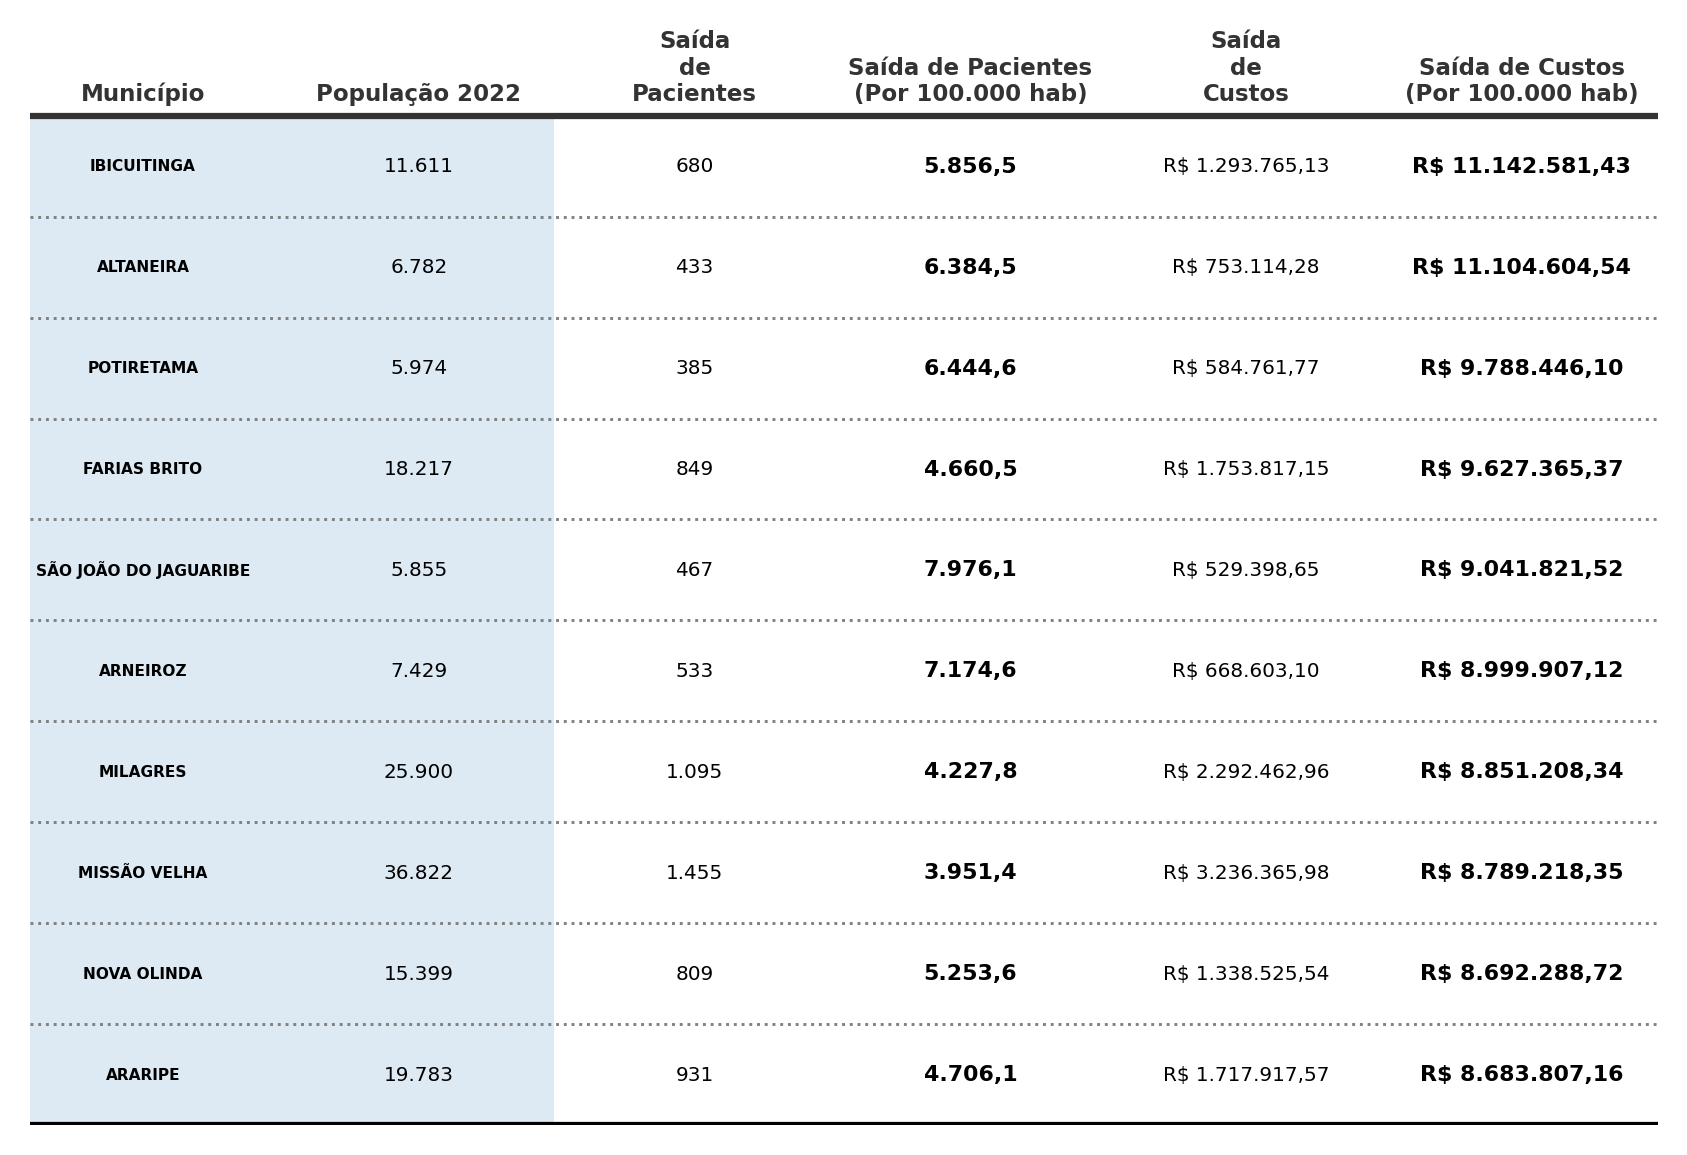

In [121]:
table_print = table2[:10][::-1].copy()

fig, ax = plt.subplots(1, figsize=(7,4.5), dpi=300)

ncols = len(table_print.columns)
nrows = table_print.shape[0]

ax.set_xlim(-1., ncols + 11)
ax.set_ylim(0, nrows+0.3)

positions = np.linspace(0.25, 15.5, ncols)
#positions = [0.25, 2., 3.3, 4.6, 5.9, ]
columns = list(table_print.columns)

# Add table's main text
for i in range(nrows):
    for j, column in enumerate(columns):
        if j == 0:
            ha = 'center'
        else:
            ha = 'center'
        v = table_print[column].iat[i]
        cus_weight = 'normal'
        fontsize = 4.8
        if column in ["Município", "Saída de Pacientes\n(Por 100.000 hab)", "Saída de Custos\n(Por 100.000 hab)"]:
             fontsize = 5.3
             cus_weight = 'bold'
             if column=="Município":
                fontsize = 3.7
        
        ax.annotate(
            xy=(positions[j], i + .5),
            text=v,
            ha=ha,
            va='center',
            fontsize=fontsize,
            weight=cus_weight
        )

# Add column names
column_names = cols
for index, c in enumerate(columns):
        if index == 0:
            ha = 'center'
        else:
            ha = 'center'
        name = columns[index]
        fontsize = 5.5
        va = 'bottom'
        ax.annotate(
            xy=(positions[index], nrows+0.1),
            text=columns[index],
            color="#333333",
            ha=ha,
            va=va,
            weight='bold',
            fontsize=fontsize,
        )

ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw=1.5, color='#333333', marker='', zorder=4)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)
for x in range(1, nrows):
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw=.7, color='gray', ls=':', zorder=3 , marker='')

ax.fill_between(
    x=[-1,4.8],
    y1=nrows,
    y2=0,
    color='tab:blue',
    alpha=0.15,
    ec='None'
)

ax.set_axis_off()
fig.savefig(basepath.joinpath("redes_aih", "doc_final", f"saida_fluxo_municipios_top10_2022.png"), dpi=250, bbox_inches='tight')

c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


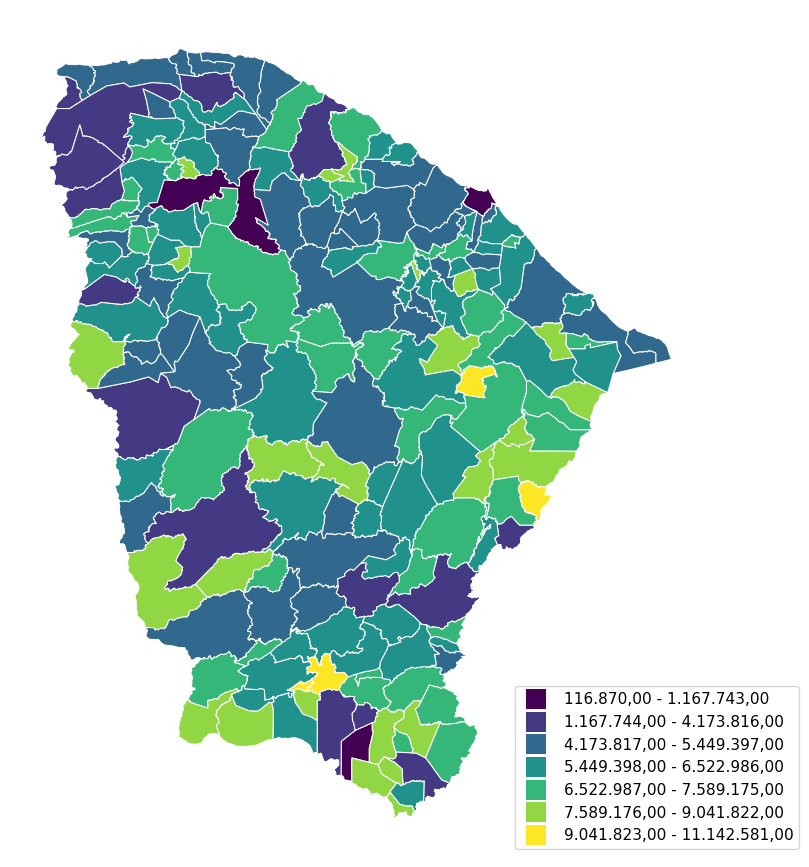

In [146]:
def transf_label(index, label, counts=None):
    label = label.replace("[", "").replace("]", "").replace("(", "")
    label = [ n.strip() for n in label.split(",") ]
    if len(label)==1:
        return label[0]
    if index==0:
        label[0] = int(label[0])
    else:
        label[0] = int(label[0])+1
    label[1] = int(label[1])
    if counts is None:
        return f'{locale.currency(label[0], grouping=True, symbol=False)} - {locale.currency(label[1], grouping=True, symbol=False)}'
    else:
        return f'{locale.currency(label[0], grouping=True, symbol=False)} - {locale.currency(label[1], grouping=True, symbol=True)} ({counts[index]})'

fig, ax = plt.subplots(1, figsize=(12,11))

geodata_df_temp1 = geodata_df.merge(table[["GEOCOD6", "Saída de Custos\n(Por 100.000 hab)"]], how="left")
map_counts = mapclassify.NaturalBreaks(geodata_df_temp1["Saída de Custos\n(Por 100.000 hab)"], k=8).counts
geodata_df_temp1.plot(ax=ax, zorder=3, column="Saída de Custos\n(Por 100.000 hab)", edgecolor="#ffffff", 
             legend=True,
             scheme="NaturalBreaks",
             k=7,
             cmap="viridis",
             linewidth=0.75,
             legend_kwds={
                 'loc': 4,
                 'prop': {'size':18},
                 'markerscale': 1.6,
                 "fmt": "{:.0f}",
                 "interval": True
             },
             missing_kwds={
                 "color": "#ffffff",
                 "edgecolor": "#404040",
                 "hatch": "///",
                 "label": '',
                 'alpha': 0.45
             })
ax.axis('off')

for index, axis in enumerate([ax]):
    leg = axis.get_legend()
    lines = leg.get_lines()
    for line in lines:
        cur_color = line.get_markerfacecolor() 
        line.set_marker('s')
        line.set_markersize(15)
    current_labels = [t.get_text() for t in leg.get_texts()]
    new_labels =  [ transf_label(index, label) for index, label in enumerate(current_labels) ]
    axis.legend(lines, new_labels, prop={'size': 11}, bbox_to_anchor=(1.15, 0.0), loc=4, title='',  title_fontproperties={'weight': 'bold', 'size': 12})
#ce_df.plot(ax=AX1, color='none', edgecolor="#333333", linewidth=2)
#macro_df.plot(ax=AX1, color="none", zorder=3, edgecolor="#1a1a1a", linewidth=2.0)
fig.savefig(basepath.joinpath("redes_aih", "doc_final", f"saida_fluxo_municipios_top10_2022_mapa.png"), dpi=250, bbox_inches='tight')

## **6. Balance flux per city (city2city)**

In [ ]:
def calculate_balance_flow(suffix_net='agg_1801_2212', geodata_df=None,
                           admission_col='admission_count', cost_col="total_cost", suffix=''):
    fname = f'cityfluxnet_{suffix_net}.gml'
    graph = nx.read_gml(os.path.join(gmlpath, 'novo_completo', fname))

    # -- include 2022 population to nodes
    pop_2022 = dict(zip(geodata_df['GEOCOD6'], geodata_df['2022']))

    for v in graph.nodes():
        muncode = graph.nodes[v]['municipio_code']
        graph.nodes[v]['pop_2022'] = pop_2022[muncode]

    # -- normalize flow based on the population
    factor = 1000
    for src, tgt in graph.edges():
        pop_src = graph.nodes[src]['pop_2022']
        outflow = graph.edges[src, tgt]['admission_count']
        outflow_cost = graph.edges[src, tgt]['total_cost']
        graph.edges[src, tgt]['admission_count_norm_pop'] = (outflow/pop_src)*factor
        graph.edges[src, tgt]['total_cost_norm_pop'] = (outflow_cost/pop_src)

    # -- calculate in and out flow for each node
    graph_prop = NetProperties(graph)
    graph_prop.calculate_in_flow(weight_people_col=admission_col, weight_cost_col=cost_col).calculate_out_flow(weight_people_col=admission_col, weight_cost_col=cost_col)
    graph_prop.calculate_internal_flow(weight_people_col=admission_col, weight_cost_col=cost_col)

    # -- calculate balance of flow of people and flow of costs
    for v in graph_prop.graph.nodes():
        inpeople, outpeople = graph_prop.graph.nodes[v]['incoming_people'], graph_prop.graph.nodes[v]['out_people']
        incost, outcost = graph_prop.graph.nodes[v]['incoming_cost'], graph_prop.graph.nodes[v]['out_cost']
        internal_people, internal_cost = graph_prop.graph.nodes[v]['internal_people'], graph_prop.graph.nodes[v]['internal_cost']
        graph_prop.graph.nodes[v]['balance_people'] = outpeople - inpeople
        graph_prop.graph.nodes[v]['balance_cost'] = outcost - incost
        graph_prop.graph.nodes[v]['balance_people_norm_inout'] = (outpeople - inpeople)/(outpeople+inpeople)
        graph_prop.graph.nodes[v]['balance_cost_norm_inout'] = (outcost - incost)/(outcost+incost)
        graph_prop.graph.nodes[v]['balance_people_norm_all'] = (outpeople - inpeople)/(outpeople+inpeople+internal_people)
        graph_prop.graph.nodes[v]['balance_cost_norm_all'] = (outcost - incost)/(outcost+incost+internal_cost)

    # -- metadata on balance
    balance_people, balance_cost = dict(), dict()
    balance_people_norm, balance_cost_norm = dict(), dict()
    balance_people_norm_all, balance_cost_norm_all = dict(), dict()
    for v in graph_prop.graph.nodes():
        muncode = graph_prop.graph.nodes[v]['municipio_code']
        bal_people, bal_cost = graph_prop.graph.nodes[v]['balance_people'], graph_prop.graph.nodes[v]['balance_cost']
        bal_people_norm, bal_cost_norm = graph_prop.graph.nodes[v]['balance_people_norm_inout'], graph_prop.graph.nodes[v]['balance_cost_norm_inout']
        bal_people_norm_all, bal_cost_norm_all = graph_prop.graph.nodes[v]['balance_people_norm_all'], graph_prop.graph.nodes[v]['balance_cost_norm_all']
        balance_people.update({muncode:bal_people})
        balance_cost.update({muncode:bal_cost})
        balance_people_norm.update({muncode:bal_people_norm})
        balance_cost_norm.update({muncode:bal_cost_norm})
        balance_people_norm_all.update({muncode:bal_people_norm_all})
        balance_cost_norm_all.update({muncode:bal_cost_norm_all})

    geodata_df_mod = geodata_df.copy()
    geodata_df_mod["balance_people"] = geodata_df_mod["GEOCOD6"].map(balance_people)
    geodata_df_mod["balance_cost"] = geodata_df_mod["GEOCOD6"].map(balance_cost)
    geodata_df_mod["balance_people_norm_inout"] = geodata_df_mod["GEOCOD6"].map(balance_people_norm)
    geodata_df_mod["balance_cost_norm_inout"] = geodata_df_mod["GEOCOD6"].map(balance_cost_norm)
    geodata_df_mod["balance_people_norm_all"] = geodata_df_mod["GEOCOD6"].map(balance_people_norm_all)
    geodata_df_mod["balance_cost_norm_all"] = geodata_df_mod["GEOCOD6"].map(balance_cost_norm_all)
    cols = ["GEOCOD6", "balance_people", "balance_cost", "balance_people_norm_inout", "balance_cost_norm_inout", "balance_people_norm_all", "balance_cost_norm_all"]
    return geodata_df_mod[cols]

In [ ]:
suffix = 'agg_self_1801_2212'
geodata_df_mod = calculate_balance_flow(suffix_net=suffix, geodata_df=geodata_df,
                                        admission_col="admission_count", cost_col='total_cost')

geodata_df_mod2 = calculate_balance_flow(suffix_net=suffix, geodata_df=geodata_df,
                                        admission_col="admission_count_ch2", cost_col='total_cost_ch2')

geodata_df_mod9 = calculate_balance_flow(suffix_net=suffix, geodata_df=geodata_df,
                                        admission_col="admission_count_ch9", cost_col='total_cost_ch9')

geodata_df_mod10 = calculate_balance_flow(suffix_net=suffix, geodata_df=geodata_df,
                                        admission_col="admission_count_ch10", cost_col='total_cost_ch10')


geodata_df_mod.to_parquet(os.path.join(gmlpath, "dados_for_plot", f"geocod_to_balance_flow_{suffix}.parquet"))
geodata_df_mod2.to_parquet(os.path.join(gmlpath, "dados_for_plot", f"geocod_to_balance_flow_{suffix}_ch2.parquet"))
geodata_df_mod9.to_parquet(os.path.join(gmlpath, "dados_for_plot", f"geocod_to_balance_flow_{suffix}_ch9.parquet"))
geodata_df_mod10.to_parquet(os.path.join(gmlpath, "dados_for_plot", f"geocod_to_balance_flow_{suffix}_ch10.parquet"))

In [ ]:
geodata_df_mod

,GEOCOD6,balance_people,balance_cost,balance_people_norm_inout,balance_cost_norm_inout,balance_people_norm_all,balance_cost_norm_all
0,230010,2190,2989678.63,1.000000,1.000000,1.000000,1.000000
1,230015,3862,4847825.38,1.000000,1.000000,1.000000,1.000000
2,230020,-3380,9553209.65,-0.225966,0.526841,-0.138474,0.429288
3,230030,3215,8221837.28,0.625122,0.882979,0.271079,0.628966
4,230040,3171,3159998.49,0.970615,0.986380,0.736072,0.865386
...,...,...,...,...,...,...,...
179,231380,5530,7817496.97,0.997115,0.998691,0.944331,0.977351
180,231390,2499,4077735.99,0.991273,0.997792,0.893777,0.958502
181,231395,3871,7151460.71,0.954624,0.988711,0.714998,0.902665
182,231400,1055,8377602.29,0.157722,0.764093,0.050772,0.500357


In [ ]:
for u in graph.nodes():
    edges = graph.in_edges(u)
    for e in edges:
        print(e, e[0])

('8', '2') 8
('28', '2') 28
('31', '2') 31
('52', '2') 52
('58', '2') 58
('70', '2') 70
('80', '2') 80
('89', '2') 89
('97', '2') 97
('99', '2') 99
('105', '2') 105
('107', '2') 107
('112', '2') 112
('118', '2') 118
('132', '2') 132
('157', '2') 157
('160', '2') 160
('161', '2') 161
('173', '2') 173
('176', '2') 176
('183', '2') 183
('13', '3') 13
('17', '3') 17
('19', '3') 19
('41', '3') 41
('49', '3') 49
('53', '3') 53
('58', '3') 58
('76', '3') 76
('99', '3') 99
('111', '3') 111
('114', '3') 114
('134', '3') 134
('141', '3') 141
('147', '3') 147
('149', '3') 149
('150', '3') 150
('155', '3') 155
('156', '3') 156
('167', '3') 167
('171', '3') 171
('3', '4') 3
('9', '4') 9
('17', '4') 17
('32', '4') 32
('41', '4') 41
('50', '4') 50
('58', '4') 58
('98', '4') 98
('134', '4') 134
('137', '4') 137
('155', '4') 155
('158', '4') 158
('171', '4') 171
('18', '6') 18
('158', '6') 158
('58', '7') 58
('82', '7') 82
('93', '7') 93
('101', '7') 101
('146', '7') 146
('154', '7') 154
('162', '7') 1

## **0. Time series of hospitals and hospital beds per macro**

In [ ]:
cnes_df = pd.read_parquet(os.path.join(cnespath, "cnes_st_0801_2312.parquet"))
leitos_df = pd.read_parquet(os.path.join(cnespath, "cnes_leitos_timeserie_0801_2312.parquet")).fillna(0)

# -- get info on macro for each CNES
cnes_macro = cnes_df.merge(geodata_df[["MACRO_ID", "MACRO_ID_PROPOSAL", "GEOCOD6"]], left_on="CODUFMUN", right_on="GEOCOD6", how="left")[["CNES", "CODUFMUN", "MACRO_ID", "MACRO_ID_PROPOSAL"]]

In [ ]:
# -- objective: for each macro, sum the number of hospital beds of the hospitals inside the macro
def count_hospitalbed_per_macro(leitos_df, macro_id, cnes_macro, macro_col="MACRO_ID"):
    ''' 
        Return the number of hospital beds (main and all) for the macrorregion for each time
        point.
    '''
    cnes_list = cnes_macro[cnes_macro[macro_col]==macro_id]["CNES"].tolist()
    subset_pri =  leitos_df.loc[:, idx[cnes_list, 'NUMLEITOS_PRINC']].sum(axis=1)
    subset_todos =  leitos_df.loc[:, idx[cnes_list, 'NUMLEITOS_TODOS']].sum(axis=1)
    macro_res = pd.DataFrame({
        "period": leitos_df.index, "macro_leitos_princ": subset_pri, "macro_leitos_todos": subset_todos
    })
    return macro_res

macro_original = { n : count_hospitalbed_per_macro(leitos_df, n, cnes_macro, macro_col="MACRO_ID") for n in range(1,5+1)  }
macro_proposal = { n : count_hospitalbed_per_macro(leitos_df, n, cnes_macro, macro_col="MACRO_ID_PROPOSAL") for n in range(1,8+1)  }

In [ ]:
macro_original = pd.concat([ macro_original[key] for key in macro_original.keys() ], axis=1, keys=macro_original.keys())
macro_proposal = pd.concat([ macro_proposal[key] for key in macro_proposal.keys() ], axis=1, keys=macro_proposal.keys())


In [ ]:
macro_original.to_parquet(os.path.join(gmlpath, "dados_for_plot", "timeserie_macro_original_beds.parquet"))
macro_proposal.to_parquet(os.path.join(gmlpath, "dados_for_plot", "timeserie_macro_proposal_beds.parquet"))


In [ ]:
macro_original.head()

1                                            2                     \
     period macro_leitos_princ macro_leitos_todos period macro_leitos_princ   
0801   0801             6406.0             9918.0   0801              499.0   
0802   0802             6450.0             9962.0   0802              499.0   
0803   0803             6450.0             9971.0   0803              499.0   
0804   0804             6611.0            10148.0   0804              499.0   
0805   0805             6632.0            10192.0   0805              499.0   

                             3                                            4  \
     macro_leitos_todos period macro_leitos_princ macro_leitos_todos period   
0801              882.0   0801              546.0              901.0   0801   
0802              882.0   0802              546.0              901.0   0802   
0803              884.0   0803              546.0              908.0   0803   
0804              884.0   0804              552.0              914.0   0804   
0805              884.0   0805              552.0              914.0   0805   

                                                5                     \
     macro_leitos_princ macro_leitos_todos period macro_leitos_princ   
0801             1389.0             2414.0   0801             2180.0   
0802             1389.0             2412.0   0802             2186.0   
0803             1389.0             2418.0   0803             2192.0   
0804             1362.0             2388.0   0804             2189.0   
0805             1365.0             2391.0   0805             2184.0   

                         
     macro_leitos_todos  
0801             3362.0  
0802             3368.0  
0803             3383.0  
0804             3371.0  
0805             3367.0

In [ ]:
macro_proposal.head()

1                                            2                     \
     period macro_leitos_princ macro_leitos_todos period macro_leitos_princ   
0801   0801             6111.0             9337.0   0801              520.0   
0802   0802             6155.0             9381.0   0802              520.0   
0803   0803             6155.0             9390.0   0803              520.0   
0804   0804             6315.0             9565.0   0804              497.0   
0805   0805             6352.0             9633.0   0805              480.0   

                             3                                            4  \
     macro_leitos_todos period macro_leitos_princ macro_leitos_todos period   
0801             1031.0   0801             1606.0             2325.0   0801   
0802             1031.0   0802             1607.0             2326.0   0802   
0803             1037.0   0803             1613.0             2337.0   0803   
0804             1005.0   0804             1613.0             2330.0   0804   
0805              980.0   0805             1613.0             2330.0   0805   

      ...                  5      6                                        \
      ... macro_leitos_todos period macro_leitos_princ macro_leitos_todos   
0801  ...              721.0   0801              558.0              929.0   
0802  ...              721.0   0802              558.0              929.0   
0803  ...              723.0   0803              558.0              936.0   
0804  ...              723.0   0804              564.0              942.0   
0805  ...              723.0   0805              564.0              942.0   

          7                                            8                     \
     period macro_leitos_princ macro_leitos_todos period macro_leitos_princ   
0801   0801              386.0              623.0   0801              855.0   
0802   0802              386.0              622.0   0802              855.0   
0803   0803              386.0              622.0   0803              855.0   
0804   0804              386.0              629.0   0804              852.0   
0805   0805              390.0              633.0   0805              852.0   

                         
     macro_leitos_todos  
0801             1474.0  
0802             1473.0  
0803             1473.0  
0804             1470.0  
0805             1470.0  

[5 rows x 24 columns]

## **1. Between cities flux networks**

### **1.1 Mapping and macros**

In [ ]:
netsuffix = "agg_2001_2012"

# -- load and perform calculations
fname = f"cityfluxnet_{netsuffix}.gml"
graph = nx.read_gml(os.path.join(gmlpath, "novo_completo", fname))
netprop = NetProperties(graph).calculate_in_flow(weight_people_col='admission_count', weight_cost_col='total_cost').calculate_out_flow(weight_people_col='admission_count', weight_cost_col='total_cost')
netprop.process_infomap_graph().process_louvain_graph()
graph = netprop.graph

# -- complementary info on graph (macro proposal)
#temp_ = dict(zip(geodata_df["GEOCOD6"], geodata_df["MACRO_ID_PROPOSAL"]))
#for v in graph.nodes():
#    graph.nodes[v]['macro_id_proposal'] = temp_[graph.nodes[v]['municipio_code']]

# -- add modules info on the geodataframe
geodata_df1 = geodata_df.copy()
geodata_df1["infomap_count_module"] = geodata_df1["GEOCOD6"].map({graph.nodes[u]['municipio_code']: graph.nodes[u]['infomap_count_module_id'] for u in graph.nodes()})
geodata_df1["infomap_cost_module"] = geodata_df1["GEOCOD6"].map({graph.nodes[u]['municipio_code']: graph.nodes[u]['infomap_cost_module_id'] for u in graph.nodes()})
geodata_df1["louvain_count_module"] = geodata_df1["GEOCOD6"].map({graph.nodes[u]['municipio_code']: graph.nodes[u]['louvain_count_module_id'] for u in graph.nodes()})
geodata_df1["louvain_cost_module"] = geodata_df1["GEOCOD6"].map({graph.nodes[u]['municipio_code']: graph.nodes[u]['louvain_cost_module_id'] for u in graph.nodes()})
geodata_df1["inflow_people"] = geodata_df1["GEOCOD6"].map({graph.nodes[u]['municipio_code']: graph.nodes[u]['incoming_people'] for u in graph.nodes()})
geodata_df1["inflow_cost"] = geodata_df1["GEOCOD6"].map({graph.nodes[u]['municipio_code']: graph.nodes[u]['incoming_cost'] for u in graph.nodes()})

found 9 modules with codelength: 2.5192578014211713
found 3 modules with codelength: 2.4760044338086376


In [ ]:
# -- specify base colors
# ---- original colors based on specific cities
# ---- new modules will be colored with the original colors if one of the cities below is included

cmap_macro_original = {1: "#ef476f", 2: "#ffb300", 3: "#04ae81", 4: "#118ab2", 5: "#073b4c"}

citycode_colors = {"230440": "#ef476f", "230730": "#073b4c", "230410": "#118ab2", "231140": "#ffb300", "231180": "#04ae81"}
citylabel_colors = {"58": "#ef476f", "98": "#073b4c", "49": "#118ab2", "150": "#ffb300", "154": "#04ae81"}
extra_colors = ["#00756a", "#bcb20f", "#ff8239", "#c6881c", "#00a2a3", "#4d4d4d", "#f0e2e7", "#dbfe87", "#1c448e"]

# -- create new cmap for new modules
#cmap_infomap_count, cmap_infomap_cost = {}, {}
#cmap_louvain_count, cmap_louvain_cost = {}, {}

def get_cmap(graph, citycode_colors, extra_colors, property_name):
    cmap = {}
    n_modules = len(set( [ graph.nodes[v][property_name] for v in graph.nodes() ] ))
    for v in graph.nodes():
        if graph.nodes[v]['municipio_code'] in citycode_colors.keys():
            if graph.nodes[v][property_name] not in cmap.keys():
                cmap.update({graph.nodes[v][property_name] : citycode_colors[graph.nodes[v]['municipio_code']]})
    extra_colors_ = extra_colors[:] + [ x for x in citycode_colors.values() if x not in cmap.values() ]
    dummy_index = 0
    for n in range(n_modules):
        if n+1 not in cmap.keys():
            cmap.update({ n+1: extra_colors_[dummy_index]})
            dummy_index+=1
    return cmap

cmap_11 = get_cmap(graph, citycode_colors, extra_colors, 'infomap_count_module_id')
cmap_13 = get_cmap(graph, citycode_colors, extra_colors, 'infomap_cost_module_id')
cmap_21 = get_cmap(graph, citycode_colors, extra_colors, 'louvain_count_module_id')
cmap_23 = get_cmap(graph, citycode_colors, extra_colors, 'louvain_cost_module_id')
#cmap_prop = get_cmap(graph, citycode_colors, extra_colors, 'macro_id_proposal')


geodata_df1["INFOMAP_COUNT_COLOR"] = geodata_df1["infomap_count_module"].map(cmap_11)
geodata_df1["INFOMAP_COST_COLOR"] = geodata_df1["infomap_cost_module"].map(cmap_13)
geodata_df1["LOUVAIN_COUNT_COLOR"] = geodata_df1["louvain_count_module"].map(cmap_21)
geodata_df1["LOUVAIN_COST_COLOR"] = geodata_df1["louvain_cost_module"].map(cmap_23)
#geodata_df1["MACRO_PROPOSAL_COLOR"] = geodata_df1["MACRO_ID_PROPOSAL"].map(cmap_prop)

In [ ]:
cmap_11

{7: '#118ab2',
 1: '#ef476f',
 2: '#073b4c',
 9: '#04ae81',
 3: '#00756a',
 4: '#bcb20f',
 5: '#ff8239',
 6: '#c6881c',
 8: '#00a2a3'}

In [ ]:
geodata_df1 = geodata_df1.drop(["centroid_municip"], axis=1)
geodata_df1.to_parquet(os.path.join(gmlpath, "dados_for_plot", f"geoforplot_{netsuffix}.parquet"))

In [ ]:
geodata_df1.columns

Index(['GEOCOD7', 'NM_MUNICIP', 'GEOCOD6', 'MACRO_ID', 'CRES_ID',
       'geometry_municip', 'MACRO_NOME', 'geometry_macro', 'geometry_cres',
       'MACRO_ID_PROPOSAL', 'municip_lon', 'municip_lat', '2010', '2011',
       '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020',
       '2021', '2022', 'MACRO_COLOR', 'infomap_count_module',
       'infomap_cost_module', 'louvain_count_module', 'louvain_cost_module',
       'inflow_people', 'inflow_cost', 'INFOMAP_COUNT_COLOR',
       'INFOMAP_COST_COLOR', 'LOUVAIN_COUNT_COLOR', 'LOUVAIN_COST_COLOR'],
      dtype='object')

### **1.1 time series networks - Fluxes over time**

In [ ]:
fnames = sorted(glob.glob(os.path.join(gmlpath, "novo_completo", "*noverlap*")))
list_of_networks = [ nx.read_gml(fname) for fname in fnames ]

**Define utility functions**

Calculate the incoming, outcoming and internal flows for each macrorregion.

In [ ]:
def get_fluxes_macro(graph, macro_indices=["1", "2", "3", "4", "5"]):
    '''
        Calculate the incoming and outgoing fluxes for each macro. Also calculate the internal flux. 
    '''
    # -- initialize flows dict.
    macro_in_out = {
        ind: {
            "INCOMING": 0,
            "OUTGOING": 0,
            "INTERNAL": 0
        } for ind in macro_indices
    }

    # -- calculation
    for src, tgt in graph.edges():
        cur_action = graph.edges[(src, tgt)]
        
        src_macro, tgt_macro = str(int(cur_action['source_macro'])), str(int(cur_action['target_macro']))
        flux_count = cur_action['admission_count']

        if src_macro==tgt_macro:
            macro_in_out[src_macro]["INTERNAL"] += flux_count
        else:
            macro_in_out[src_macro]["OUTGOING"] += flux_count
            macro_in_out[tgt_macro]["INCOMING"] += flux_count
    return macro_in_out

def macro_flows_time(list_of_graphs, macro_indices=["1", "2", "3", "4", "5"]):
    ''' 
    
    '''
    # -- initialize flows dict.
    macro_in_out = {
        ind: {
            "INCOMING": [],
            "OUTGOING": [],
            "INTERNAL": []
        } for ind in macro_indices
    }
    for graph in list_of_graphs:
        res = get_fluxes_macro(graph)
        for key in res.keys():
            macro_in_out[key]["INCOMING"].append(res[key]["INCOMING"])
            macro_in_out[key]["OUTGOING"].append(res[key]["OUTGOING"])
            macro_in_out[key]["INTERNAL"].append(res[key]["INTERNAL"])
    return macro_in_out

In [ ]:
macro_flows = macro_flows_time(list_of_networks)
with open(os.path.join(gmlpath, 'dados_for_plot', 'macro_original_fluxes.pickle'), 'wb') as handle:
    pickle.dump(macro_flows, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import graph_tool as gt
from graph_tool.inference import minimize_blockmodel_dl

In [ ]:
fname = "cityfluxnet_agg_1801_2212.gml"
graph = gt.load_graph(os.path.join(gmlpath, "novo_completo", fname))

In [ ]:
state = minimize_blockmodel_dl(graph)
modules_v = state.get_blocks()

In [ ]:
# YYMM
fname = "cityfluxnet_agg_1801_2212.gml"
graph = nx.read_gml(os.path.join(gmlpath, "novo_completo", fname))

In [ ]:
for v in graph.nodes():
    break
graph.nodes[v]

{'municipio_code': '230010',
 'municipio_name': 'ABAIARA',
 'macro_id': 5,
 'macro_new_id': 3,
 'macro_name': 'Superintendência Regional de Saúde Cariri',
 'cres_id': 19,
 'lat': -7.35990681440754,
 'lon': -39.03753839591732}

In [ ]:
for u, v in graph.edges():
    break
graph.edges[(u,v)]

{'admission_count': 27,
 'total_cost': 16354.65,
 'source_macro': 5.0,
 'target_macro': 5,
 'source_micro': 19.0,
 'target_micro': 19,
 'same_macro': 5.0,
 'same_micro': 19.0,
 'admission_count_ch1': 0.0,
 'total_cost_ch1': 0.0,
 'admission_count_ch2': 0.0,
 'total_cost_ch2': 0.0,
 'admission_count_ch3': 0.0,
 'total_cost_ch3': 0.0,
 'admission_count_ch4': 0.0,
 'total_cost_ch4': 0.0,
 'admission_count_ch5': 0.0,
 'total_cost_ch5': 0.0,
 'admission_count_ch6': 0.0,
 'total_cost_ch6': 0.0,
 'admission_count_ch7': 0.0,
 'total_cost_ch7': 0.0,
 'admission_count_ch8': 0.0,
 'total_cost_ch8': 0.0,
 'admission_count_ch9': 0.0,
 'total_cost_ch9': 0.0,
 'admission_count_ch10': 0.0,
 'total_cost_ch10': 0.0,
 'admission_count_ch11': 6.0,
 'total_cost_ch11': 3420.04,
 'admission_count_ch12': 0.0,
 'total_cost_ch12': 0.0,
 'admission_count_ch13': 1.0,
 'total_cost_ch13': 948.13,
 'admission_count_ch14': 6.0,
 'total_cost_ch14': 2934.94,
 'admission_count_ch15': 14.0,
 'total_cost_ch15': 9051.54,
 

## **2. Cities to Hospitals flux networks**